In [11]:
!pip install pandas

In [12]:
import pandas as pd
import sys
from pathlib import Path
sys.path.append('../../scripts')
from plotting_utils.helpers import load_present_day

In [13]:
# Set matplotlib theme to match plot_ac_sar_pdfs.py style
import matplotlib
matplotlib.rcParams["font.family"] = "monospace"


In [14]:
df = pd.read_pickle('rollouts_dataframe.pkl')

In [15]:
class EmpiricalCDF:
    """Fast empirical CDF using sorted data and binary search."""
    def __init__(self, data):
        self.sorted_data = np.sort(data[~np.isnan(data)])
        self.n = len(self.sorted_data)
    
    def __call__(self, x):
        """Evaluate CDF at point(s) x."""
        x = np.asarray(x)
        # Use searchsorted to find insertion points (left side)
        # This gives the count of values <= x
        indices = np.searchsorted(self.sorted_data, x, side='right')
        return indices / self.n
    
    def quantile(self, p):
        """Get quantile at probability p."""
        if self.n == 0:
            return np.nan
        idx = np.clip(np.round(p * (self.n - 1)).astype(int), 0, self.n - 1)
        return self.sorted_data[idx]


In [16]:
display([key for key in df.keys()])

['has_error',
 'param.present_doubling_time',
 'param.doubling_difficulty_growth_factor',
 'param.ai_research_taste_slope',
 'param.ai_research_taste_at_coding_automation_anchor_sd',
 'param.gap_years',
 'param.pre_gap_ac_time_horizon',
 'param.ac_time_horizon_minutes',
 'param.coding_automation_efficiency_slope',
 'param.inv_compute_anchor_exp_cap',
 'param.inf_compute_asymptote',
 'param.present_day',
 'param.present_horizon',
 'param.rho_coding_labor',
 'param.inf_labor_asymptote',
 'param.parallel_penalty',
 'param.swe_multiplier_at_present_day',
 'param.max_serial_coding_labor_multiplier',
 'param.median_to_top_taste_multiplier',
 'param.software_progress_rate_at_reference_year',
 'param.ted_ai_m2b',
 'param.asi_above_siar_vs_tedai_above_sar_difficulty',
 'param.r_software',
 'ts_param.slowdown_year',
 'ts_param.constant_training_compute_growth_rate',
 'ts_param.post_slowdown_training_compute_growth_rate',
 'milestone.AC.time',
 'milestone.AC.target',
 'milestone.AC.progress_multi

In [17]:
df['milestone.SAR-level-experiment-selection-skill.time']

sample_id
0       2025.959433
1       2026.896532
2       2031.125818
3       2032.518270
4       2028.517409
           ...     
9995    2026.861541
9996    2032.421781
9997    2058.532358
9998    2027.024402
9999    2028.034163
Name: milestone.SAR-level-experiment-selection-skill.time, Length: 10000, dtype: float64

In [18]:
diff = df['milestone.SAR-level-experiment-selection-skill.time'] - df['milestone.AC.time']


In [19]:
# Check for missing/invalid values in all columns
print("DataFrame shape:", df.shape)
print("\n" + "="*60)
print("Checking for NaN values:")
print("="*60)
nan_counts = df.isna().sum()
if nan_counts.sum() > 0:
    print("Found NaN values:")
    print(nan_counts[nan_counts > 0])
else:
    print("No NaN values found")

print("\n" + "="*60)
print("Checking for None values:")
print("="*60)
none_counts = df.isin([None]).sum()
if none_counts.sum() > 0:
    print("Found None values:")
    print(none_counts[none_counts > 0])
else:
    print("No None values found")

print("\n" + "="*60)
print("Checking for zero values:")
print("="*60)
zero_counts = (df == 0).sum()
if zero_counts.sum() > 0:
    print("Found zero values:")
    print(zero_counts[zero_counts > 0])
else:
    print("No zero values found")

print("\n" + "="*60)
print("Checking for negative values:")
print("="*60)
negative_counts = (df < 0).sum()
if negative_counts.sum() > 0:
    print("Found negative values:")
    print(negative_counts[negative_counts > 0])
else:
    print("No negative values found")

print("\n" + "="*60)
print("Summary statistics:")
print("="*60)
print(df.describe())


DataFrame shape: (10000, 126)

Checking for NaN values:
Found NaN values:
param.r_software                       564
milestone.AC.time                      654
milestone.AC.target                    564
milestone.AC.progress_multiplier       654
milestone.AC.effective_compute_ooms    654
                                      ... 
top_taste_num_sds                      564
f_multiplier_per_sd                    564
slope_times_log_f                      564
metr_mse                               564
simulation_end                         564
Length: 101, dtype: int64

Checking for None values:
Found None values:
param.r_software                       564
milestone.AC.time                      654
milestone.AC.target                    564
milestone.AC.progress_multiplier       654
milestone.AC.effective_compute_ooms    654
                                      ... 
top_taste_num_sds                      564
f_multiplier_per_sd                    564
slope_times_log_f                    

In [20]:
# Calculate percentage of NaN values for each milestone
total_rows = len(df)
nan_percentages = (df.isna().sum() / total_rows * 100).sort_values(ascending=False)

print("Percentage of NaN values for each milestone:")
print("="*60)
for milestone, percentage in nan_percentages.items():
    count = df[milestone].isna().sum()
    print(f"{milestone:50s}: {percentage:6.2f}% ({count:,} / {total_rows:,})")


Percentage of NaN values for each milestone:
milestone.Maximum possible experiment selection skill.time:  49.92% (4,992 / 10,000)
milestone.Maximum possible experiment selection skill.progress_multiplier:  49.92% (4,992 / 10,000)
milestone.Maximum possible experiment selection skill.research_stock:  49.92% (4,992 / 10,000)
milestone.Maximum possible experiment selection skill.effective_compute_ooms:  49.92% (4,992 / 10,000)
milestone.Maximum possible experiment selection skill.research_effort:  49.92% (4,992 / 10,000)
milestone.AIR-10000x.time                         :  18.10% (1,810 / 10,000)
milestone.AIR-10000x.effective_compute_ooms       :  18.10% (1,810 / 10,000)
milestone.AIR-10000x.research_stock               :  18.10% (1,810 / 10,000)
milestone.AIR-10000x.research_effort              :  18.10% (1,810 / 10,000)
milestone.ASI.effective_compute_ooms              :  16.80% (1,680 / 10,000)
milestone.ASI.research_stock                      :  16.80% (1,680 / 10,000)
milestone.ASI.

In [ ]:
import sys
sys.path.append('../../scripts')
from plotting_utils.kde import make_gamma_kernel_kde
import numpy as np

# Set lower bound (present day) - adjust if needed
present_day = 2022.0

# Apply gamma kernel KDE to each milestone column
kde_dict = {}
for col in df.columns:
    # Drop NaN values and filter to values >= lower_bound
    data = df[col].dropna().values
    data = data[data >= present_day]
    
    if len(data) < 2:
        print(f"Skipping {col}: insufficient data ({len(data)} valid samples)")
        continue
    
    try:
        kde = make_gamma_kernel_kde(data, lower_bound=present_day)
        kde_dict[col] = kde
        print(f"{col}: KDE created successfully (bandwidth={kde.bandwidth:.4f}, n={len(data)})")
    except Exception as e:
        print(f"{col}: Failed to create KDE - {e}")

print(f"\nSuccessfully created {len(kde_dict)} KDEs")


Skipping has_error: insufficient data (0 valid samples)
Skipping param.present_doubling_time: insufficient data (0 valid samples)
Skipping param.doubling_difficulty_growth_factor: insufficient data (0 valid samples)
Skipping param.ai_research_taste_slope: insufficient data (0 valid samples)
Skipping param.ai_research_taste_at_coding_automation_anchor_sd: insufficient data (0 valid samples)
Skipping param.gap_years: insufficient data (0 valid samples)
param.pre_gap_ac_time_horizon: KDE created successfully (bandwidth=6719.6925, n=9889)


In [ ]:
# Create performant empirical CDFs for each milestone
# Create CDFs for all milestones
cdf_dict = {}
for col in df.columns:
    data = df[col].values
    if len(data[~np.isnan(data)]) > 0:
        cdf_dict[col] = EmpiricalCDF(data)
        print(f"{col}: CDF created (n={cdf_dict[col].n})")
    else:
        print(f"{col}: Skipped (no valid data)")

print(f"\nCreated {len(cdf_dict)} CDFs")


has_error: CDF created (n=10000)
param.present_doubling_time: CDF created (n=10000)
param.doubling_difficulty_growth_factor: CDF created (n=10000)
param.ai_research_taste_slope: CDF created (n=10000)
param.ai_research_taste_at_coding_automation_anchor_sd: CDF created (n=10000)
param.gap_years: CDF created (n=10000)
param.pre_gap_ac_time_horizon: CDF created (n=10000)
param.ac_time_horizon_minutes: CDF created (n=10000)
param.coding_automation_efficiency_slope: CDF created (n=10000)
param.inv_compute_anchor_exp_cap: CDF created (n=10000)
param.inf_compute_asymptote: CDF created (n=10000)
param.present_day: CDF created (n=10000)
param.present_horizon: CDF created (n=10000)
param.rho_coding_labor: CDF created (n=10000)
param.inf_labor_asymptote: CDF created (n=10000)
param.parallel_penalty: CDF created (n=10000)
param.swe_multiplier_at_present_day: CDF created (n=10000)
param.max_serial_coding_labor_multiplier: CDF created (n=10000)
param.median_to_top_taste_multiplier: CDF created (n=100

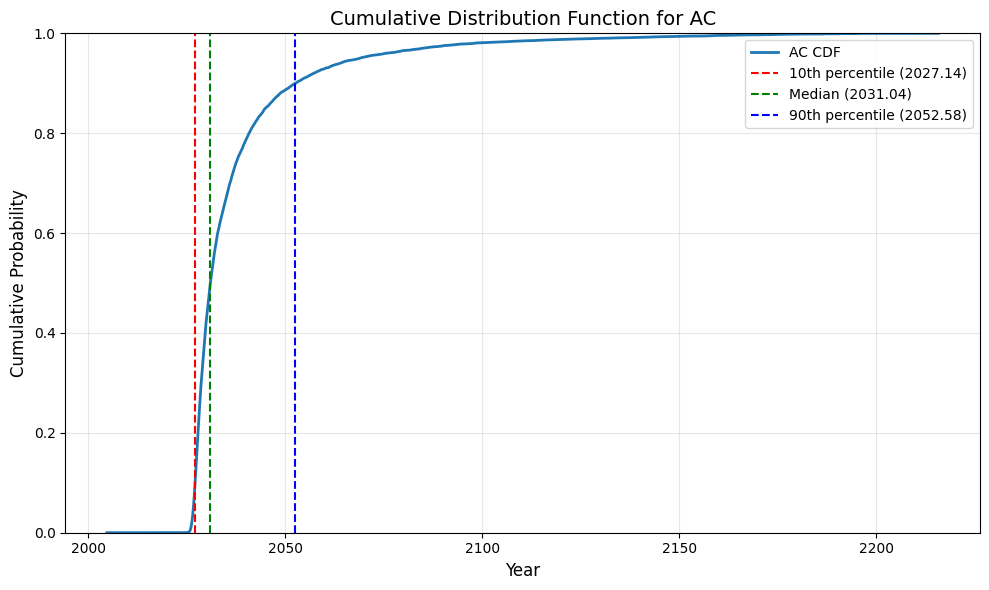

AC Statistics:
  Min: 2022.34
  Max: 2198.22
  Median (50th percentile): 2031.04
  10th percentile: 2027.14
  90th percentile: 2052.58


In [ ]:
# Plot CDF for AC
ac_cdf = cdf_dict['AC']
ac_data = df['AC'].dropna().values

# Calculate percentiles
p10 = ac_cdf.quantile(0.1)
p50 = ac_cdf.quantile(0.5)
p90 = ac_cdf.quantile(0.9)

# Create evaluation points
x_min = ac_data.min()
x_max = ac_data.max()
x_range = x_max - x_min
# Add some padding
x_eval = np.linspace(x_min - 0.1 * x_range, x_max + 0.1 * x_range, 1000)
cdf_values = ac_cdf(x_eval)

plt.figure(figsize=(10, 6))
plt.plot(x_eval, cdf_values, linewidth=2, label='AC CDF')
plt.axvline(p10, color='red', linestyle='--', linewidth=1.5, label=f'10th percentile ({p10:.2f})')
plt.axvline(p50, color='green', linestyle='--', linewidth=1.5, label=f'Median ({p50:.2f})')
plt.axvline(p90, color='blue', linestyle='--', linewidth=1.5, label=f'90th percentile ({p90:.2f})')
plt.xlabel('Year', fontsize=12)
plt.ylabel('Cumulative Probability', fontsize=12)
plt.title('Cumulative Distribution Function for AC', fontsize=14)
plt.grid(True, alpha=0.3)
plt.ylim(0, 1)
plt.legend()
plt.tight_layout()
plt.show()

# Print some statistics
print(f"AC Statistics:")
print(f"  Min: {x_min:.2f}")
print(f"  Max: {x_max:.2f}")
print(f"  Median (50th percentile): {p50:.2f}")
print(f"  10th percentile: {p10:.2f}")
print(f"  90th percentile: {p90:.2f}")


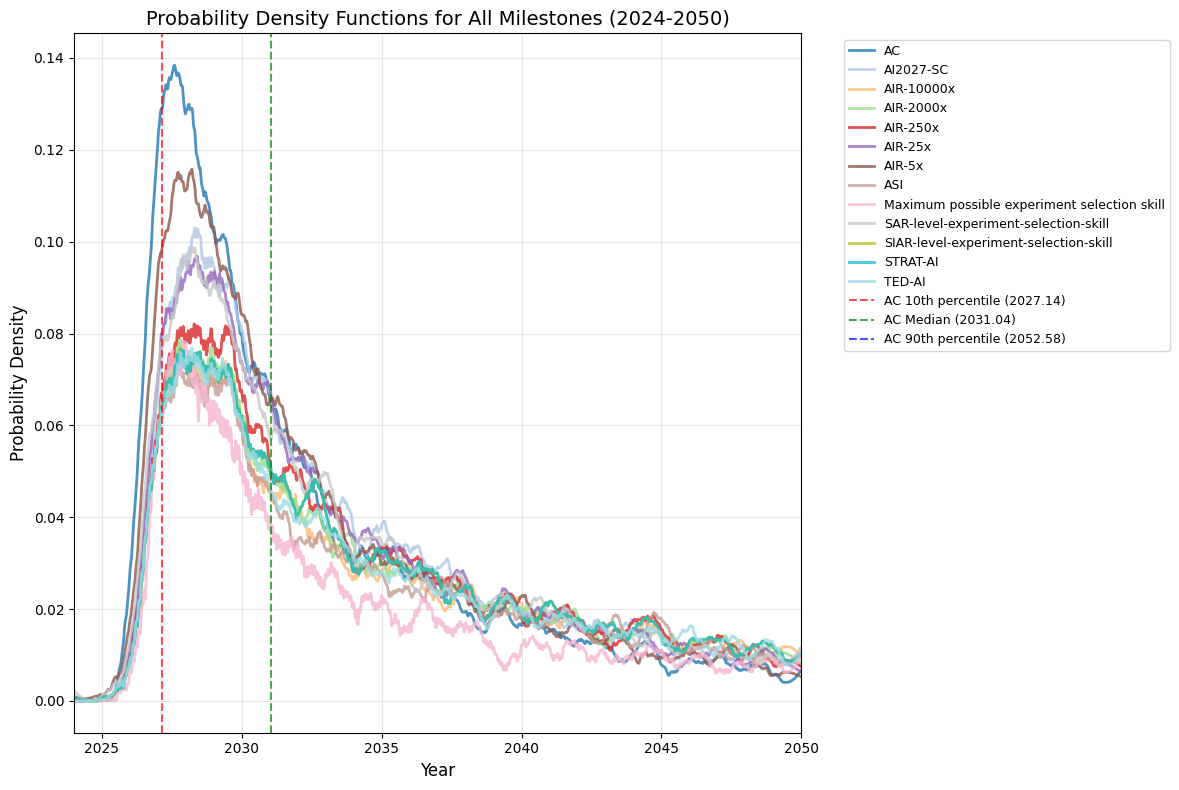

In [ ]:
# Plot PDFs for all milestones (empirically by differentiating CDF)
from scipy.signal import savgol_filter
import matplotlib.cm as cm

# Set plot range
x_min_plot = 2024
x_max_plot = 2050
x_eval = np.linspace(x_min_plot, x_max_plot, 1000)
dx = x_eval[1] - x_eval[0]

# Helper function to compute smoothed PDF from CDF
def compute_pdf_from_cdf(cdf, x_eval):
    cdf_values = cdf(x_eval)
    
    # Apply smoothing to CDF before differentiation
    window_length = min(51, len(cdf_values) // 10 * 2 + 1)
    if window_length < 5:
        window_length = 5
    window_length = window_length if window_length % 2 == 1 else window_length + 1
    polyorder = min(3, window_length - 2)
    cdf_smooth = savgol_filter(cdf_values, window_length, polyorder)
    
    # Ensure CDF stays monotonic and in [0, 1]
    cdf_smooth = np.clip(cdf_smooth, 0, 1)
    for i in range(1, len(cdf_smooth)):
        cdf_smooth[i] = max(cdf_smooth[i], cdf_smooth[i-1])
    
    # Compute PDF by differentiating smoothed CDF
    pdf_values = np.gradient(cdf_smooth, dx)
    pdf_values = np.maximum(pdf_values, 0)
    return pdf_values

# Get AC percentiles for reference lines
ac_cdf = cdf_dict['AC']
p10 = ac_cdf.quantile(0.1)
p50 = ac_cdf.quantile(0.5)
p90 = ac_cdf.quantile(0.9)

# Create colormap for different milestones
colors = cm.tab20(np.linspace(0, 1, len(cdf_dict)))

plt.figure(figsize=(12, 8))
for idx, (milestone, cdf) in enumerate(cdf_dict.items()):
    try:
        pdf_values = compute_pdf_from_cdf(cdf, x_eval)
        plt.plot(x_eval, pdf_values, linewidth=2, label=milestone, color=colors[idx], alpha=0.8)
    except Exception as e:
        print(f"Warning: Could not compute PDF for {milestone}: {e}")

# Add AC percentile reference lines
plt.axvline(p10, color='red', linestyle='--', linewidth=1.5, alpha=0.7, label=f'AC 10th percentile ({p10:.2f})')
plt.axvline(p50, color='green', linestyle='--', linewidth=1.5, alpha=0.7, label=f'AC Median ({p50:.2f})')
plt.axvline(p90, color='blue', linestyle='--', linewidth=1.5, alpha=0.7, label=f'AC 90th percentile ({p90:.2f})')

plt.xlabel('Year', fontsize=12)
plt.ylabel('Probability Density', fontsize=12)
plt.title('Probability Density Functions for All Milestones (2024-2050)', fontsize=14)
plt.xlim(x_min_plot, x_max_plot)
plt.grid(True, alpha=0.3)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=9)
plt.tight_layout()
plt.show()


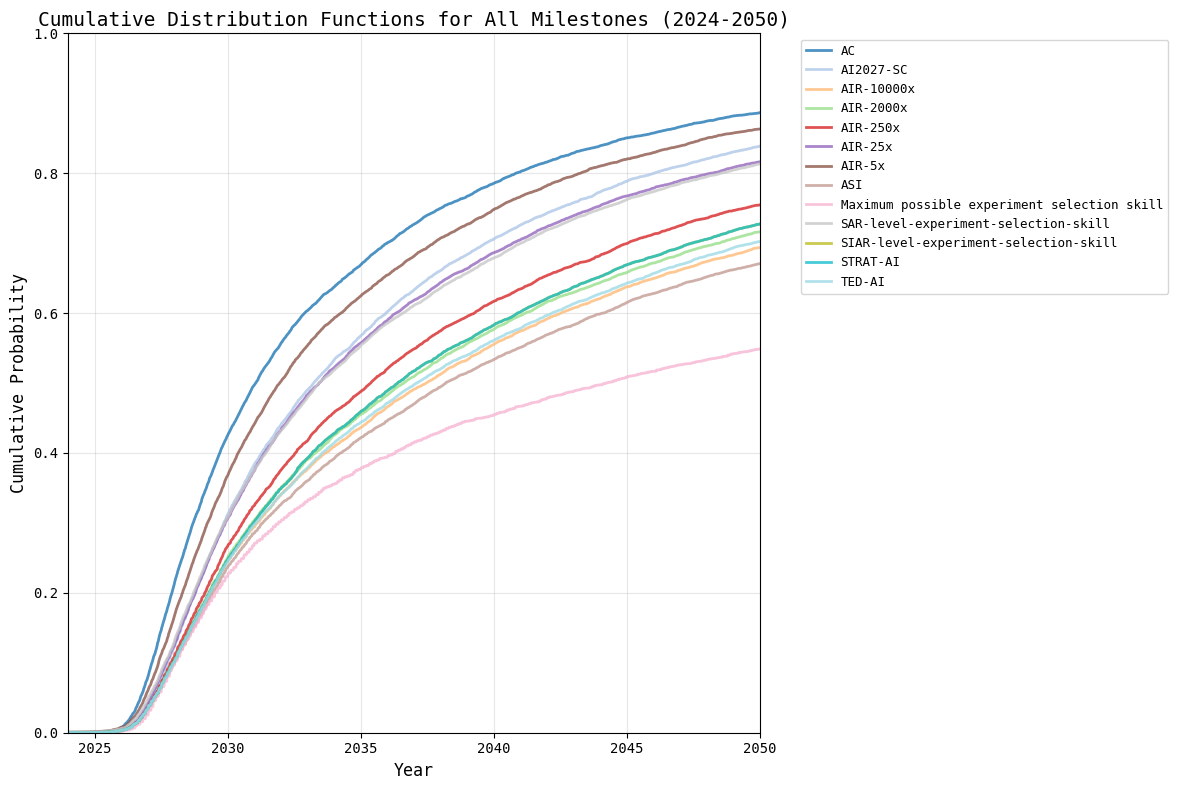

In [ ]:
# Plot empirical CDFs for all milestones
x_min_plot = 2024
x_max_plot = 2050
x_eval = np.linspace(x_min_plot, x_max_plot, 1000)

# Create colormap for different milestones (same as PDF plot)
colors = cm.tab20(np.linspace(0, 1, len(cdf_dict)))

plt.figure(figsize=(12, 8))
for idx, (milestone, cdf) in enumerate(cdf_dict.items()):
    try:
        cdf_values = cdf(x_eval)
        plt.plot(x_eval, cdf_values, linewidth=2, label=milestone, color=colors[idx], alpha=0.8)
    except Exception as e:
        print(f"Warning: Could not compute CDF for {milestone}: {e}")

plt.xlabel('Year', fontsize=12)
plt.ylabel('Cumulative Probability', fontsize=12)
plt.title('Cumulative Distribution Functions for All Milestones (2024-2050)', fontsize=14)
plt.xlim(x_min_plot, x_max_plot)
plt.ylim(0, 1)
plt.grid(True, alpha=0.3)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=9)
plt.tight_layout()
plt.show()


In [ ]:
kde_dict['AC']

Parameter: param.ai_research_taste_at_coding_automation_anchor_sd
Total non-NaN values: 10,000

Distribution statistics:
  Min: -8.084649
  25th percentile: -1.090885
  50th percentile (median): 0.506468
  75th percentile: 2.104106
  99th percentile: 5.909460
  Max: 9.768667
  Mean: 0.523888
  Std: 2.335828

99.9th percentile of standard normal: 3.090232

Values exceeding 99.9th percentile of standard normal (3.090232):
  Count: 1,345
  Fraction: 13.4500% (1,345 / 10,000)
  Expected fraction if standard normal: 0.1%


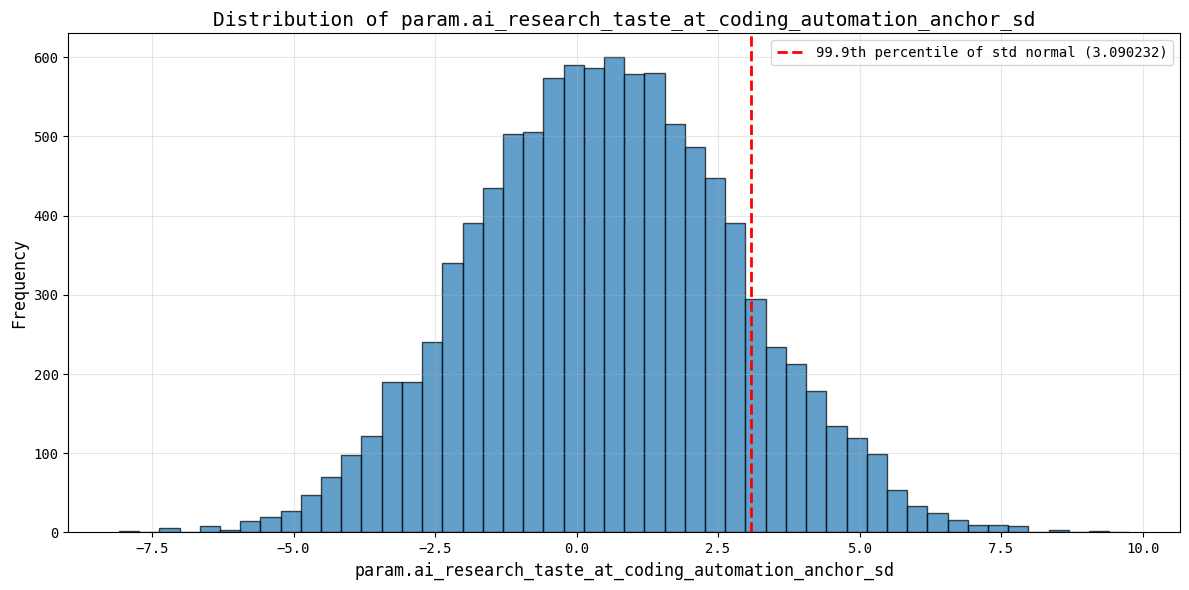


Values exceeding 99.9th percentile of standard normal:
sample_id
9055    9.768667
9702    9.273510
8116    9.224419
3252    8.455335
433     8.410712
2277    8.408514
9250    8.183679
8894    7.923226
9489    7.918063
280     7.867680
9112    7.824230
1003    7.771857
3000    7.751620
9582    7.690845
5123    7.651335
5326    7.614112
160     7.541727
355     7.537091
9394    7.517879
3533    7.513545
... and 1325 more


Found 13 milestones
Milestones: AC, AI2027-SC, AIR-10000x, AIR-2000x, AIR-250x, AIR-25x, AIR-5x, ASI, Maximum possible experiment selection skill, SAR-level-experiment-selection-skill, SIAR-level-experiment-selection-skill, STRAT-AI, TED-AI

CSV saved to: milestone_median_differences.csv

Note: Values show median(time_column - time_row) in years
      NaN indicates insufficient data for that pair


Using columns: slope_times_log_f and r_software

Statistics:
  Total non-NaN pairs: 9,436
  Greater than 1: 3,540 (37.52%)
  Min: -19.604793
  25th percentile: 0.279429
  50th percentile (median): 0.681417
  75th percentile: 1.497652
  99th percentile: 9.843379
  Max: 39.937354
  Mean: 1.273927
  Std: 2.201190


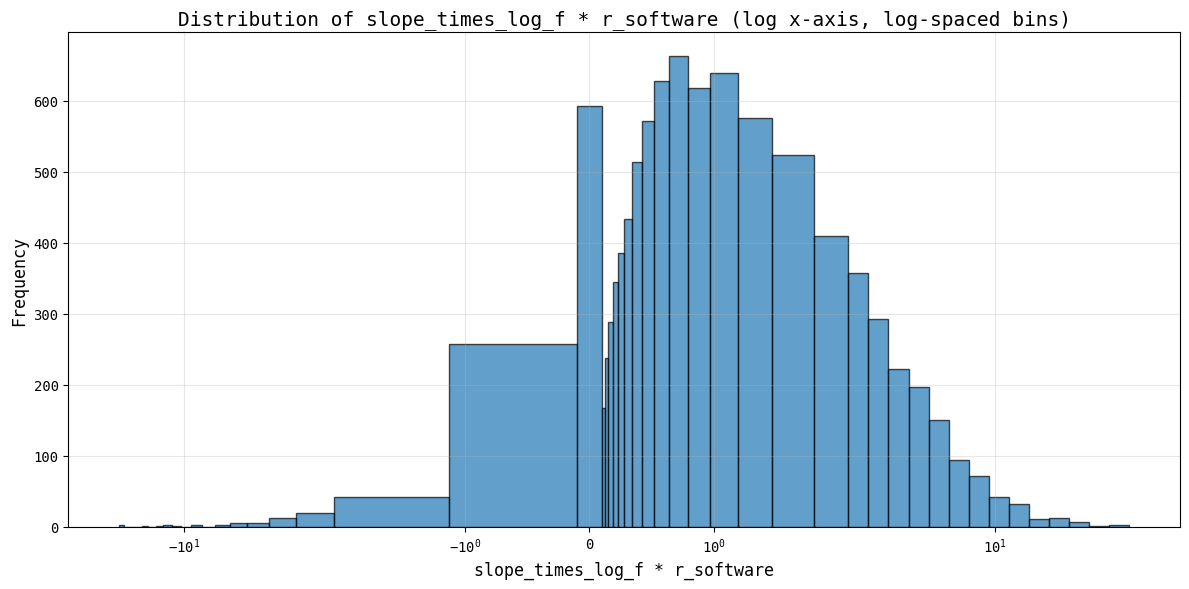

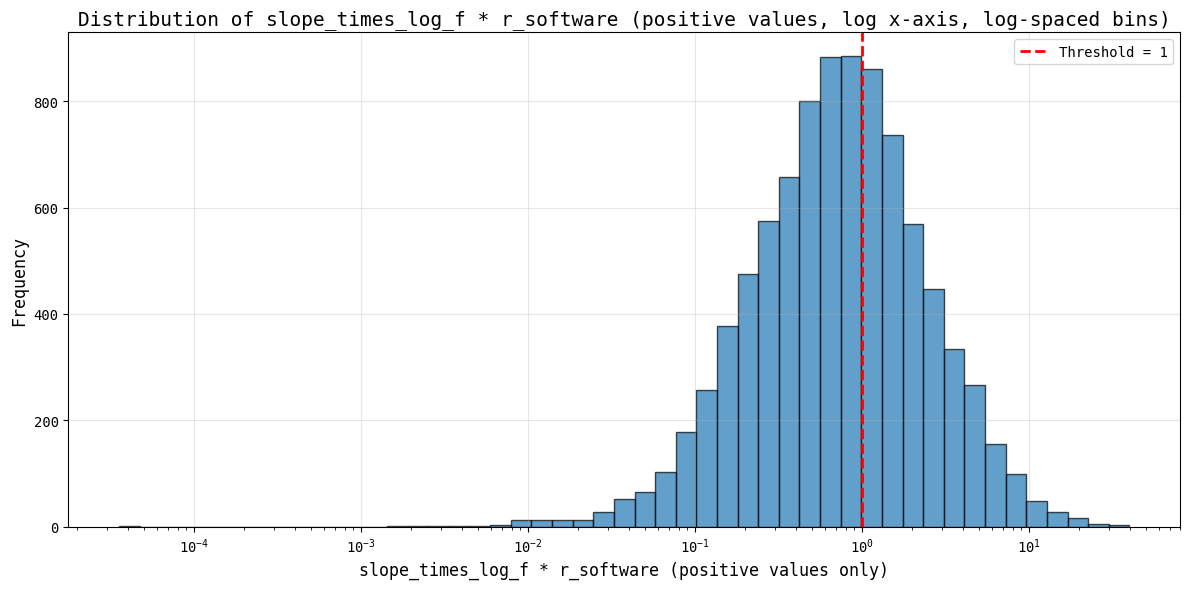

In [ ]:
# Calculate fraction non-positive for each variable separately
col1 = 'slope_times_log_f'
col2 = 'r_software'

if col1 in df.columns and col2 in df.columns:
    # For slope_times_log_f
    col1_non_nan = df[col1].notna()
    col1_non_positive = (df.loc[col1_non_nan, col1] <= 0).sum()
    col1_total = col1_non_nan.sum()
    col1_fraction = col1_non_positive / col1_total if col1_total > 0 else 0
    
    # For r_software
    col2_non_nan = df[col2].notna()
    col2_non_positive = (df.loc[col2_non_nan, col2] <= 0).sum()
    col2_total = col2_non_nan.sum()
    col2_fraction = col2_non_positive / col2_total if col2_total > 0 else 0
    
    print(f"Fraction non-positive (<= 0):")
    print(f"  {col1}: {col1_fraction:.2%} ({col1_non_positive:,} / {col1_total:,})")
    print(f"  {col2}: {col2_fraction:.2%} ({col2_non_positive:,} / {col2_total:,})")
    
    # Also show product for reference
    both_non_nan = col1_non_nan & col2_non_nan
    product = df.loc[both_non_nan, col1] * df.loc[both_non_nan, col2]
    product_non_positive = (product <= 0).sum()
    product_total = len(product)
    product_fraction = product_non_positive / product_total if product_total > 0 else 0
    print(f"  Product ({col1} * {col2}): {product_fraction:.2%} ({product_non_positive:,} / {product_total:,})")
else:
    print("Columns not found")


Fraction non-positive (<= 0):
  slope_times_log_f: 0.00% (0 / 9,436)
  r_software: 4.97% (469 / 9,436)
  Product (slope_times_log_f * r_software): 4.97% (469 / 9,436)


In [ ]:
# Filter to runs with r_software non-positive and show statistics
col1 = 'slope_times_log_f'
col2 = 'r_software'

if col2 in df.columns:
    # Filter to runs where r_software is non-positive
    r_software_non_positive = df[col2] <= 0
    df_filtered = df[r_software_non_positive].copy()
    
    total_runs = len(df_filtered)
    print(f"Runs with r_software <= 0: {total_runs:,}")
    print(f"Fraction of all runs: {total_runs / len(df):.2%}")
    print()
    
    if total_runs > 0:
        # Statistics on r_software
        r_software_vals = df_filtered[col2].dropna()
        if len(r_software_vals) > 0:
            print(f"Statistics on r_software (filtered runs):")
            print(f"  Count: {len(r_software_vals):,}")
            print(f"  Min: {r_software_vals.min():.6f}")
            print(f"  25th percentile: {r_software_vals.quantile(0.25):.6f}")
            print(f"  50th percentile (median): {r_software_vals.quantile(0.50):.6f}")
            print(f"  75th percentile: {r_software_vals.quantile(0.75):.6f}")
            print(f"  Max: {r_software_vals.max():.6f}")
            print(f"  Mean: {r_software_vals.mean():.6f}")
            print(f"  Std: {r_software_vals.std():.6f}")
            print()
        
        # Statistics on slope_times_log_f for these runs
        if col1 in df_filtered.columns:
            slope_vals = df_filtered[col1].dropna()
            if len(slope_vals) > 0:
                print(f"Statistics on slope_times_log_f (filtered runs):")
                print(f"  Count: {len(slope_vals):,}")
                print(f"  Min: {slope_vals.min():.6f}")
                print(f"  25th percentile: {slope_vals.quantile(0.25):.6f}")
                print(f"  50th percentile (median): {slope_vals.quantile(0.50):.6f}")
                print(f"  75th percentile: {slope_vals.quantile(0.75):.6f}")
                print(f"  Max: {slope_vals.max():.6f}")
                print(f"  Mean: {slope_vals.mean():.6f}")
                print(f"  Std: {slope_vals.std():.6f}")
                print()
        
        # Statistics on product
        both_non_nan = df_filtered[col1].notna() & df_filtered[col2].notna()
        if both_non_nan.sum() > 0:
            product = df_filtered.loc[both_non_nan, col1] * df_filtered.loc[both_non_nan, col2]
            print(f"Statistics on product ({col1} * {col2}) (filtered runs):")
            print(f"  Count: {len(product):,}")
            print(f"  Min: {product.min():.6f}")
            print(f"  25th percentile: {product.quantile(0.25):.6f}")
            print(f"  50th percentile (median): {product.quantile(0.50):.6f}")
            print(f"  75th percentile: {product.quantile(0.75):.6f}")
            print(f"  Max: {product.max():.6f}")
            print(f"  Mean: {product.mean():.6f}")
            print(f"  Std: {product.std():.6f}")
            print()
            print(f"  Fraction > 1: {(product > 1).sum() / len(product):.2%}")
            print(f"  Fraction <= 0: {(product <= 0).sum() / len(product):.2%}")
    else:
        print("No runs found with r_software <= 0")
else:
    print(f"Column '{col2}' not found")


Runs with r_software <= 0: 469
Fraction of all runs: 4.69%

Statistics on r_software (filtered runs):
  Count: 469
  Min: -6.294915
  25th percentile: -1.189644
  50th percentile (median): -0.642854
  75th percentile: -0.255537
  Max: -0.000160
  Mean: -0.921638
  Std: 0.954290

Statistics on slope_times_log_f (filtered runs):
  Count: 469
  Min: 0.020975
  25th percentile: 0.294117
  50th percentile (median): 0.615500
  75th percentile: 1.148248
  Max: 16.608022
  Mean: 1.045574
  Std: 1.424585

Statistics on product (slope_times_log_f * r_software) (filtered runs):
  Count: 469
  Min: -19.604793
  25th percentile: -0.901462
  50th percentile (median): -0.355740
  75th percentile: -0.101266
  Max: -0.000094
  Mean: -1.033354
  Std: 2.179379

  Fraction > 1: 0.00%
  Fraction <= 0: 100.00%


In [ ]:
# Create milestone arrival median table for runs with negative r_software
import numpy as np
col2 = 'r_software'

if col2 in df.columns:
    # Filter to runs where r_software is negative (< 0)
    r_software_negative = df[col2] < 0
    df_filtered = df[r_software_negative].copy()
    
    total_runs = len(df_filtered)
    print(f"Runs with r_software < 0: {total_runs:,}")
    print(f"Fraction of all runs: {total_runs / len(df):.2%}")
    print()
    
    if total_runs > 0:
        # Get all milestone time columns
        time_cols = [col for col in df_filtered.columns if col.endswith('.time')]
        time_cols = sorted(time_cols)
        
        # Extract milestone names
        milestone_names = [col.replace('milestone.', '').replace('.time', '') for col in time_cols]
        
        # Calculate medians for each milestone
        print("Milestone Arrival Median Times (years):")
        print("=" * 70)
        print(f"{'Milestone':<50} {'Median Arrival Time':>20}")
        print("-" * 70)
        
        medians = []
        for col, name in zip(time_cols, milestone_names):
            values = df_filtered[col].dropna()
            if len(values) > 0:
                median_val = values.median()
                medians.append((name, median_val, len(values)))
                print(f"{name:<50} {median_val:>20.2f}")
            else:
                medians.append((name, np.nan, 0))
                print(f"{name:<50} {'NaN (no data)':>20}")
        
        print("-" * 70)
        print(f"\nTotal runs: {total_runs:,}")
        
        # Also create a summary showing how many runs achieved each milestone
        print("\nMilestone Achievement Counts:")
        print("=" * 70)
        print(f"{'Milestone':<50} {'Achieved':>15} {'Fraction':>15}")
        print("-" * 70)
        for name, median_val, count in medians:
            fraction = count / total_runs if total_runs > 0 else 0
            print(f"{name:<50} {count:>15,} {fraction:>15.2%}")
    else:
        print("No runs found with r_software < 0")
else:
    print(f"Column '{col2}' not found")


Runs with r_software < 0: 469
Fraction of all runs: 4.69%

Milestone Arrival Median Times (years):
Milestone                                           Median Arrival Time
----------------------------------------------------------------------
AC                                                              2034.62
AI2027-SC                                                       2042.47
AIR-10000x                                                NaN (no data)
AIR-2000x                                                 NaN (no data)
AIR-250x                                                  NaN (no data)
AIR-25x                                                   NaN (no data)
AIR-5x                                                    NaN (no data)
ASI                                                             2059.19
Maximum possible experiment selection skill                     2109.30
SAR-level-experiment-selection-skill                            2041.54
SIAR-level-experiment-selection-skill 

In [ ]:
# Create filtered JSONL file with only rollouts that have negative r_software
import json
from pathlib import Path

col2 = 'r_software'
rollouts_file = Path('rollouts.jsonl')
output_file = Path('rollouts-negative-r.jsonl')

if col2 in df.columns and rollouts_file.exists():
    # Filter to runs where r_software is negative (< 0)
    r_software_negative = df[col2] < 0
    df_filtered = df[r_software_negative].copy()
    
    # Get sample_ids (index of dataframe)
    sample_ids = set(df_filtered.index)
    total_runs = len(sample_ids)
    
    print(f"Filtering rollouts with r_software < 0")
    print(f"Target sample_ids: {total_runs:,}")
    print(f"Reading from: {rollouts_file}")
    print(f"Writing to: {output_file}")
    print()
    
    # Read rollouts.jsonl and filter
    written_count = 0
    skipped_count = 0
    
    with open(rollouts_file, 'r', encoding='utf-8') as infile, \
         open(output_file, 'w', encoding='utf-8') as outfile:
        
        for line_num, line in enumerate(infile, 1):
            line = line.strip()
            if not line:
                continue
            
            try:
                rollout = json.loads(line)
                sample_id = rollout.get('sample_id')
                
                if sample_id in sample_ids:
                    outfile.write(line + '\n')
                    written_count += 1
                else:
                    skipped_count += 1
                
                if line_num % 1000 == 0:
                    print(f"  Processed {line_num:,} lines, written {written_count:,}, skipped {skipped_count:,}...")
            
            except json.JSONDecodeError as e:
                print(f"Warning: Skipping invalid JSON on line {line_num}: {e}")
                skipped_count += 1
                continue
    
    print()
    print(f"Completed!")
    print(f"  Total lines processed: {line_num:,}")
    print(f"  Rollouts written: {written_count:,}")
    print(f"  Rollouts skipped: {skipped_count:,}")
    print(f"  Output file: {output_file}")
    
    if written_count != total_runs:
        print(f"  Warning: Expected {total_runs:,} rollouts but wrote {written_count:,}")
    
elif not rollouts_file.exists():
    print(f"Error: {rollouts_file} not found")
elif col2 not in df.columns:
    print(f"Error: Column '{col2}' not found in dataframe")


Filtering rollouts with r_software < 0
Target sample_ids: 469
Reading from: rollouts.jsonl
Writing to: rollouts-negative-r.jsonl

  Processed 1,000 lines, written 35, skipped 965...
  Processed 2,000 lines, written 75, skipped 1,925...
  Processed 3,000 lines, written 118, skipped 2,882...
  Processed 4,000 lines, written 163, skipped 3,837...
  Processed 5,000 lines, written 218, skipped 4,782...
  Processed 6,000 lines, written 273, skipped 5,727...
  Processed 7,000 lines, written 334, skipped 6,666...
  Processed 8,000 lines, written 378, skipped 7,622...
  Processed 9,000 lines, written 423, skipped 8,577...
  Processed 10,000 lines, written 469, skipped 9,531...

Completed!
  Total lines processed: 10,000
  Rollouts written: 469
  Rollouts skipped: 9,531
  Output file: rollouts-negative-r.jsonl


In [ ]:
# Create filtered JSONL file with only samples that have negative r_software
import json
from pathlib import Path

col2 = 'r_software'
samples_file = Path('samples.jsonl')
output_file = Path('samples-negative-r.jsonl')

if col2 in df.columns and samples_file.exists():
    # Filter to runs where r_software is negative (< 0)
    r_software_negative = df[col2] < 0
    df_filtered = df[r_software_negative].copy()
    
    # Get sample_ids (index of dataframe)
    sample_ids = set(df_filtered.index)
    total_runs = len(sample_ids)
    
    print(f"Filtering samples with r_software < 0")
    print(f"Target sample_ids: {total_runs:,}")
    print(f"Reading from: {samples_file}")
    print(f"Writing to: {output_file}")
    print()
    
    # Read samples.jsonl and filter
    written_count = 0
    skipped_count = 0
    
    with open(samples_file, 'r', encoding='utf-8') as infile, \
         open(output_file, 'w', encoding='utf-8') as outfile:
        
        for line_num, line in enumerate(infile, 1):
            line = line.strip()
            if not line:
                continue
            
            try:
                sample = json.loads(line)
                sample_id = sample.get('sample_id')
                
                if sample_id in sample_ids:
                    outfile.write(line + '\n')
                    written_count += 1
                else:
                    skipped_count += 1
                
                if line_num % 1000 == 0:
                    print(f"  Processed {line_num:,} lines, written {written_count:,}, skipped {skipped_count:,}...")
            
            except json.JSONDecodeError as e:
                print(f"Warning: Skipping invalid JSON on line {line_num}: {e}")
                skipped_count += 1
                continue
    
    print()
    print(f"Completed!")
    print(f"  Total lines processed: {line_num:,}")
    print(f"  Samples written: {written_count:,}")
    print(f"  Samples skipped: {skipped_count:,}")
    print(f"  Output file: {output_file}")
    
    if written_count != total_runs:
        print(f"  Warning: Expected {total_runs:,} samples but wrote {written_count:,}")
    
elif not samples_file.exists():
    print(f"Error: {samples_file} not found")
elif col2 not in df.columns:
    print(f"Error: Column '{col2}' not found in dataframe")


Filtering samples with r_software < 0
Target sample_ids: 469
Reading from: samples.jsonl
Writing to: samples-negative-r.jsonl

  Processed 1,000 lines, written 35, skipped 965...
  Processed 2,000 lines, written 75, skipped 1,925...
  Processed 3,000 lines, written 118, skipped 2,882...
  Processed 4,000 lines, written 163, skipped 3,837...
  Processed 5,000 lines, written 218, skipped 4,782...
  Processed 6,000 lines, written 273, skipped 5,727...
  Processed 7,000 lines, written 334, skipped 6,666...
  Processed 8,000 lines, written 378, skipped 7,622...
  Processed 9,000 lines, written 423, skipped 8,577...
  Processed 10,000 lines, written 469, skipped 9,531...

Completed!
  Total lines processed: 10,000
  Samples written: 469
  Samples skipped: 9,531
  Output file: samples-negative-r.jsonl


Dataset statistics for param.software_progress_rate_at_reference_year:
  Entire dataset: 10,000 non-NaN values
  Negative r_software subset: 469 non-NaN values

Entire dataset statistics:
  Min: -1.424951
  25th percentile: 0.734408
  50th percentile (median): 1.247212
  75th percentile: 1.751638
  Max: 4.759895
  Mean: 1.246236
  Std: 0.745137

Negative r_software subset statistics:
  Min: -1.424951
  25th percentile: -0.389519
  50th percentile (median): -0.214059
  75th percentile: -0.091282
  Max: -0.000077
  Mean: -0.282773
  Std: 0.254695



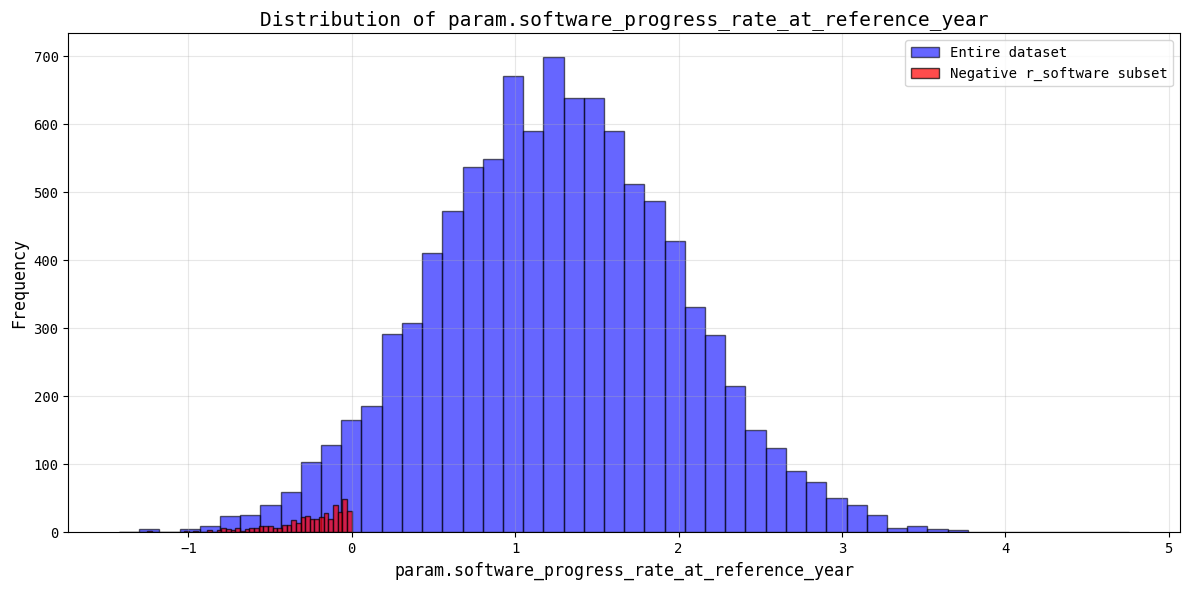

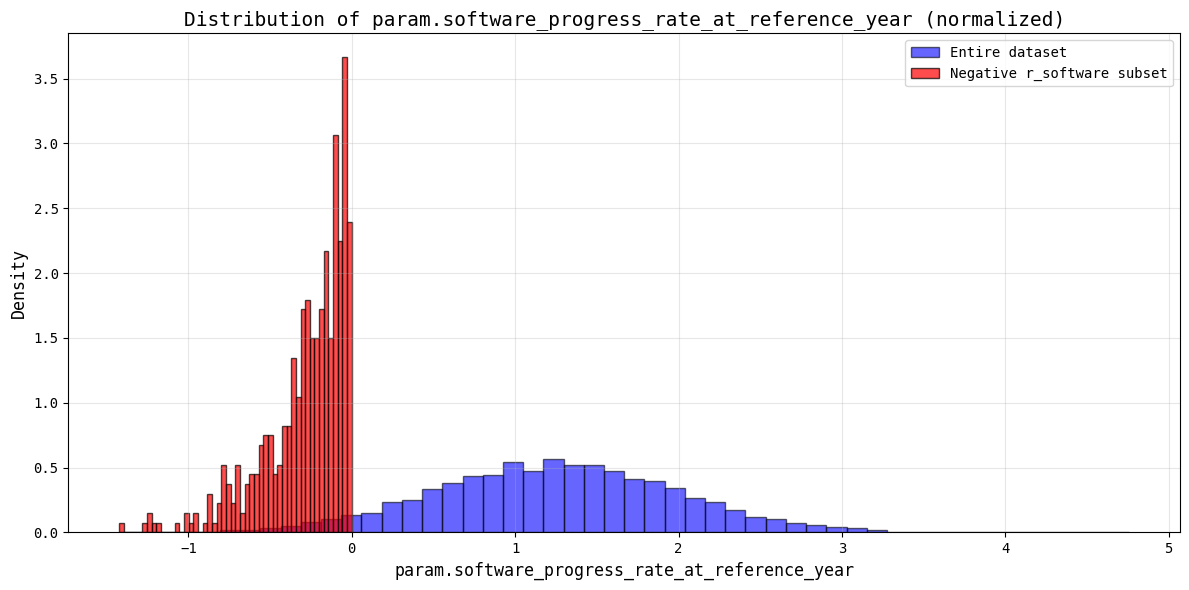

In [ ]:
# Plot histogram of software_progress_rate_at_reference_year for entire dataset and negative r_software subset
import numpy as np
import matplotlib.pyplot as plt

# Try different possible column names
col_candidates = [
    'param.software_progress_rate_at_reference_year',
    'software_progress_rate_at_reference_year',
    'param.software_progress_rate',
    'software_progress_rate'
]

col_name = None
for candidate in col_candidates:
    if candidate in df.columns:
        col_name = candidate
        break

r_software_col = 'r_software'

if col_name is None:
    print(f"Could not find column. Available columns containing 'software':")
    print([c for c in df.columns if 'software' in c.lower()][:20])
elif col_name is not None and col_name in df.columns and r_software_col in df.columns:
    # Get values for entire dataset
    all_values = df[col_name].dropna()
    
    # Filter to runs with negative r_software
    r_software_negative = df[r_software_col] < 0
    negative_r_values = df.loc[r_software_negative, col_name].dropna()
    
    print(f"Dataset statistics for {col_name}:")
    print(f"  Entire dataset: {len(all_values):,} non-NaN values")
    print(f"  Negative r_software subset: {len(negative_r_values):,} non-NaN values")
    print()
    
    if len(all_values) > 0:
        print(f"Entire dataset statistics:")
        print(f"  Min: {all_values.min():.6f}")
        print(f"  25th percentile: {all_values.quantile(0.25):.6f}")
        print(f"  50th percentile (median): {all_values.quantile(0.50):.6f}")
        print(f"  75th percentile: {all_values.quantile(0.75):.6f}")
        print(f"  Max: {all_values.max():.6f}")
        print(f"  Mean: {all_values.mean():.6f}")
        print(f"  Std: {all_values.std():.6f}")
        print()
    
    if len(negative_r_values) > 0:
        print(f"Negative r_software subset statistics:")
        print(f"  Min: {negative_r_values.min():.6f}")
        print(f"  25th percentile: {negative_r_values.quantile(0.25):.6f}")
        print(f"  50th percentile (median): {negative_r_values.quantile(0.50):.6f}")
        print(f"  75th percentile: {negative_r_values.quantile(0.75):.6f}")
        print(f"  Max: {negative_r_values.max():.6f}")
        print(f"  Mean: {negative_r_values.mean():.6f}")
        print(f"  Std: {negative_r_values.std():.6f}")
        print()
    
    # Plot overlaid histograms
    plt.figure(figsize=(12, 6))
    
    if len(all_values) > 0:
        plt.hist(all_values, bins=50, alpha=0.6, label='Entire dataset', 
                edgecolor='black', color='blue', density=False)
    
    if len(negative_r_values) > 0:
        plt.hist(negative_r_values, bins=50, alpha=0.7, label='Negative r_software subset',
                edgecolor='black', color='red', density=False)
    
    plt.xlabel(col_name, fontsize=12)
    plt.ylabel('Frequency', fontsize=12)
    plt.title(f'Distribution of {col_name}', fontsize=14)
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    # Plot normalized (density) histograms for better comparison
    if len(all_values) > 0 and len(negative_r_values) > 0:
        plt.figure(figsize=(12, 6))
        plt.hist(all_values, bins=50, alpha=0.6, label='Entire dataset', 
                edgecolor='black', color='blue', density=True)
        plt.hist(negative_r_values, bins=50, alpha=0.7, label='Negative r_software subset',
                edgecolor='black', color='red', density=True)
        plt.xlabel(col_name, fontsize=12)
        plt.ylabel('Density', fontsize=12)
        plt.title(f'Distribution of {col_name} (normalized)', fontsize=14)
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()
    
else:
    if col_name not in df.columns:
        print(f"Error: Column '{col_name}' not found in dataframe")
    if r_software_col not in df.columns:
        print(f"Error: Column '{r_software_col}' not found in dataframe")


Found 46 parameters with bounds

Found 4 parameters with samples exceeding bounds:
Parameter                                             Below Min    Above Max Total Exceeding     Fraction
----------------------------------------------------------------------------------------------------
r_software                                                  508          495           1,003       10.63%
software_progress_rate_at_reference_year                    557            0             557        5.57%
ai_research_taste_slope                                       4          424             428        4.28%
median_to_top_taste_multiplier                                8          328             336        3.36%

Plotting histograms for parameters exceeding bounds...



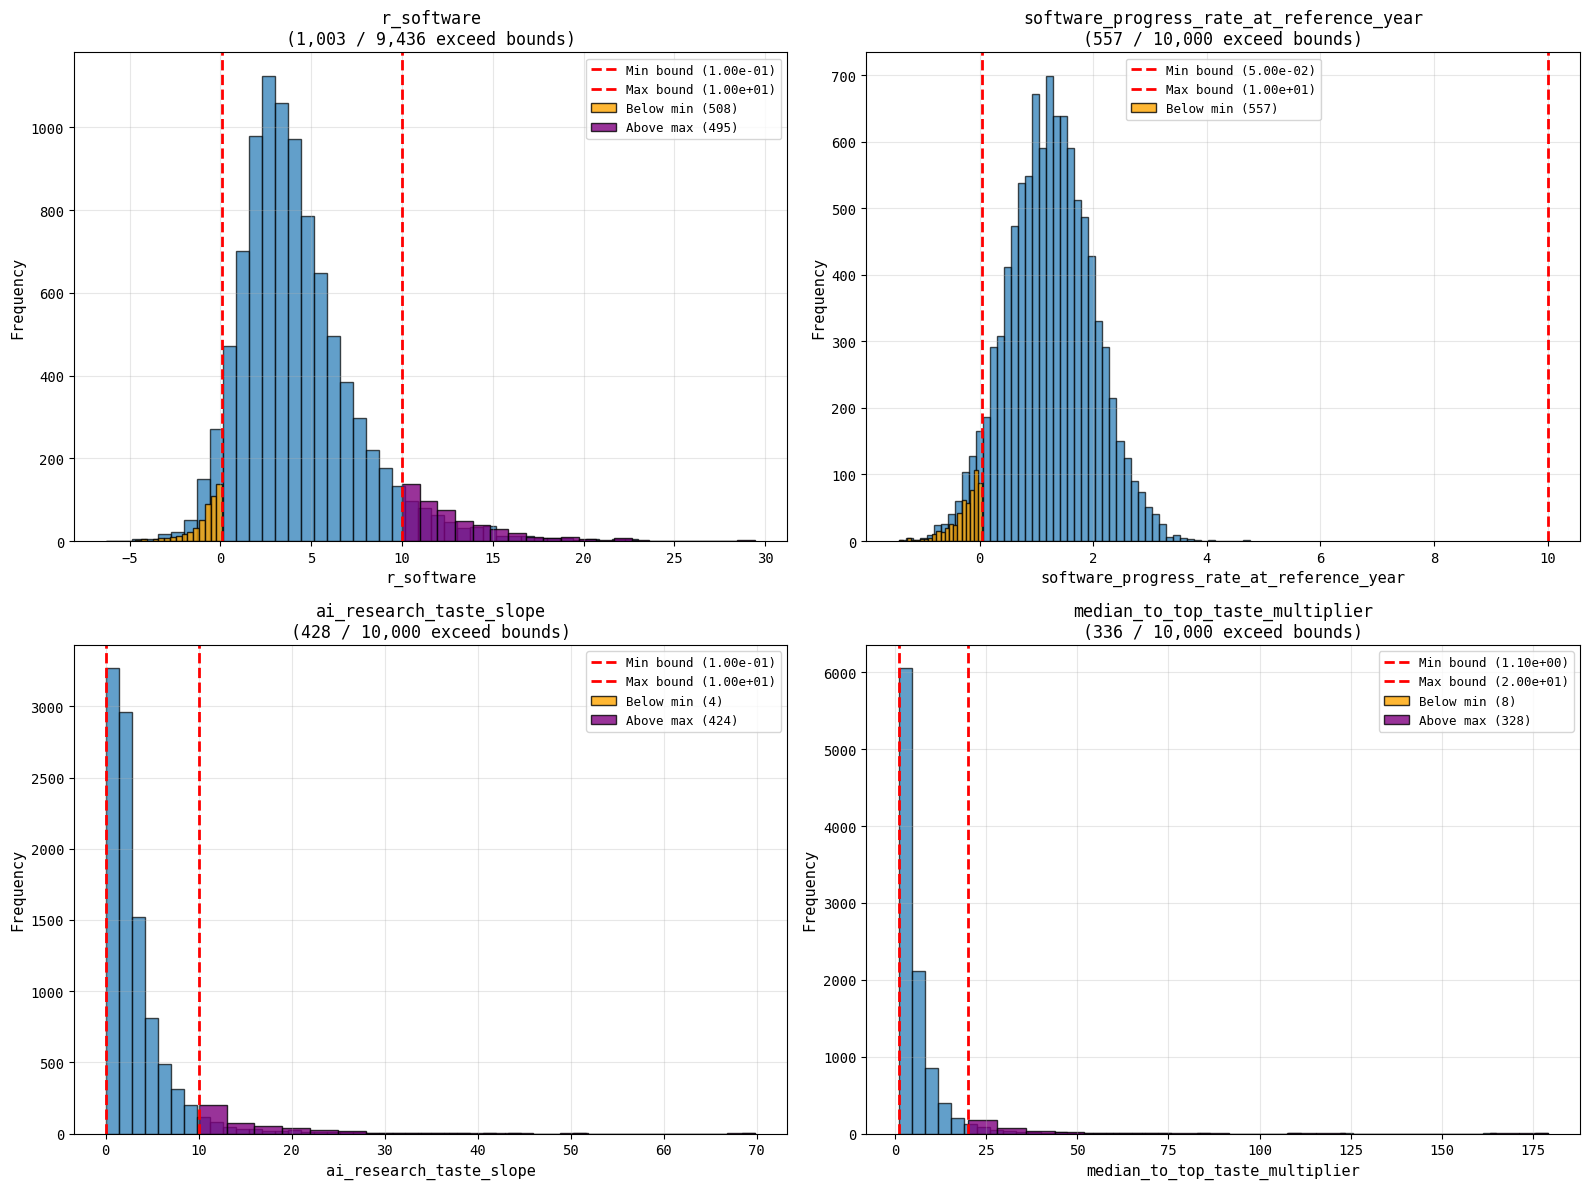

In [ ]:
# Check for parameters exceeding bounds from model_config_snapshot.json
import json
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

config_file = Path('model_config_snapshot.json')

if not config_file.exists():
    print(f"Error: {config_file} not found")
else:
    # Load parameter bounds
    with open(config_file, 'r') as f:
        config = json.load(f)
    
    parameter_bounds = config.get('PARAMETER_BOUNDS', {})
    
    if not parameter_bounds:
        print("No PARAMETER_BOUNDS found in config file")
    else:
        print(f"Found {len(parameter_bounds)} parameters with bounds")
        print()
        
        # Check each parameter
        exceeding_params = []
        
        for param_name, bounds in parameter_bounds.items():
            if len(bounds) != 2:
                continue
            
            min_bound, max_bound = bounds[0], bounds[1]
            
            # Try to find the parameter column (could be param.* or direct name)
            param_col = None
            for col_candidate in [f'param.{param_name}', param_name]:
                if col_candidate in df.columns:
                    param_col = col_candidate
                    break
            
            if param_col is None:
                continue
            
            # Check for values exceeding bounds
            values = df[param_col].dropna()
            if len(values) == 0:
                continue
            
            below_min = (values < min_bound).sum()
            above_max = (values > max_bound).sum()
            total_exceeding = below_min + above_max
            
            if total_exceeding > 0:
                exceeding_params.append({
                    'name': param_name,
                    'column': param_col,
                    'min_bound': min_bound,
                    'max_bound': max_bound,
                    'below_min': below_min,
                    'above_max': above_max,
                    'total_exceeding': total_exceeding,
                    'total_samples': len(values),
                    'fraction_exceeding': total_exceeding / len(values)
                })
        
        # Report results
        if exceeding_params:
            print(f"Found {len(exceeding_params)} parameters with samples exceeding bounds:")
            print("=" * 100)
            print(f"{'Parameter':<50} {'Below Min':>12} {'Above Max':>12} {'Total Exceeding':>15} {'Fraction':>12}")
            print("-" * 100)
            
            for param in exceeding_params:
                print(f"{param['name']:<50} {param['below_min']:>12,} {param['above_max']:>12,} "
                      f"{param['total_exceeding']:>15,} {param['fraction_exceeding']:>12.2%}")
            
            print()
            print("Plotting histograms for parameters exceeding bounds...")
            print()
            
            # Plot histograms
            n_params = len(exceeding_params)
            n_cols = 2
            n_rows = (n_params + 1) // 2
            
            fig, axes = plt.subplots(n_rows, n_cols, figsize=(16, 6 * n_rows))
            if n_params == 1:
                axes = [axes]
            else:
                axes = axes.flatten()
            
            for idx, param in enumerate(exceeding_params):
                ax = axes[idx]
                values = df[param['column']].dropna()
                
                ax.hist(values, bins=50, edgecolor='black', alpha=0.7)
                ax.axvline(param['min_bound'], color='red', linestyle='--', linewidth=2, 
                          label=f"Min bound ({param['min_bound']:.2e})")
                ax.axvline(param['max_bound'], color='red', linestyle='--', linewidth=2,
                          label=f"Max bound ({param['max_bound']:.2e})")
                
                # Highlight exceeding values
                below_min_vals = values[values < param['min_bound']]
                above_max_vals = values[values > param['max_bound']]
                
                if len(below_min_vals) > 0:
                    ax.hist(below_min_vals, bins=20, alpha=0.8, color='orange', 
                           edgecolor='black', label=f'Below min ({len(below_min_vals)})')
                if len(above_max_vals) > 0:
                    ax.hist(above_max_vals, bins=20, alpha=0.8, color='purple',
                           edgecolor='black', label=f'Above max ({len(above_max_vals)})')
                
                ax.set_xlabel(param['name'], fontsize=11)
                ax.set_ylabel('Frequency', fontsize=11)
                ax.set_title(f"{param['name']}\n({param['total_exceeding']:,} / {param['total_samples']:,} exceed bounds)", 
                           fontsize=12)
                ax.legend(fontsize=9)
                ax.grid(True, alpha=0.3)
            
            # Hide unused subplots
            for idx in range(n_params, len(axes)):
                axes[idx].set_visible(False)
            
            plt.tight_layout()
            plt.show()
            
        else:
            print("No parameters found with samples exceeding bounds.")


In [ ]:
# Analyze error rates for combinations of parameters exceeding bounds
import json
import numpy as np
import pandas as pd
from pathlib import Path
from itertools import combinations

config_file = Path('model_config_snapshot.json')

# First, check for error indicators in the dataframe
print("Checking for error indicators in dataframe...")
error_indicators = []
for col in df.columns:
    col_lower = col.lower()
    if any(term in col_lower for term in ['error', 'failed', 'exception', 'status']):
        error_indicators.append(col)
        print(f"  Found potential error column: {col}")

# Also check if missing milestones might indicate errors
# (runs that failed might not have milestone times)
milestone_cols = [col for col in df.columns if col.endswith('.time')]
if milestone_cols:
    # Consider a run as potentially errored if ALL milestones are NaN
    all_milestones_nan = df[milestone_cols].isna().all(axis=1)
    error_indicators.append('all_milestones_nan')
    print(f"  Created indicator: all_milestones_nan ({all_milestones_nan.sum():,} runs)")

print()

if not config_file.exists():
    print(f"Error: {config_file} not found")
else:
    # Load parameter bounds
    with open(config_file, 'r') as f:
        config = json.load(f)
    
    parameter_bounds = config.get('PARAMETER_BOUNDS', {})
    
    if not parameter_bounds:
        print("No PARAMETER_BOUNDS found in config file")
    else:
        # Identify parameters that exceed bounds
        exceeding_params_info = []
        
        for param_name, bounds in parameter_bounds.items():
            if len(bounds) != 2:
                continue
            
            min_bound, max_bound = bounds[0], bounds[1]
            
            # Try to find the parameter column
            param_col = None
            for col_candidate in [f'param.{param_name}', param_name]:
                if col_candidate in df.columns:
                    param_col = col_candidate
                    break
            
            if param_col is None:
                continue
            
            # Check for values exceeding bounds
            values = df[param_col].dropna()
            if len(values) == 0:
                continue
            
            exceeds_min = df[param_col] < min_bound
            exceeds_max = df[param_col] > max_bound
            exceeds_bounds = exceeds_min | exceeds_max
            
            if exceeds_bounds.sum() > 0:
                exceeding_params_info.append({
                    'name': param_name,
                    'column': param_col,
                    'exceeds_mask': exceeds_bounds.fillna(False)
                })
        
        print(f"Found {len(exceeding_params_info)} parameters with samples exceeding bounds")
        print()
        
        if len(exceeding_params_info) == 0:
            print("No parameters exceed bounds, nothing to analyze.")
        else:
            # Calculate base error rate
            if 'all_milestones_nan' in error_indicators:
                error_mask = all_milestones_nan
                error_col_name = 'all_milestones_nan'
            elif error_indicators:
                # Use first error indicator found
                error_mask = df[error_indicators[0]].notna() & (df[error_indicators[0]] != 0)
                error_col_name = error_indicators[0]
            else:
                print("No error indicators found. Using all_milestones_nan as proxy.")
                error_mask = all_milestones_nan
                error_col_name = 'all_milestones_nan'
            
            base_error_rate = error_mask.sum() / len(df)
            print(f"Base error rate ({error_col_name}): {base_error_rate:.2%} ({error_mask.sum():,} / {len(df):,})")
            print()
            
            # Analyze single parameter exceeding bounds
            print("Single parameter exceeding bounds:")
            print("=" * 100)
            print(f"{'Parameter':<50} {'Exceeds':>12} {'Errors':>12} {'Error Rate':>15} {'vs Base':>15}")
            print("-" * 100)
            
            single_param_results = []
            for param_info in exceeding_params_info:
                exceeds = param_info['exceeds_mask']
                errors_in_exceeds = (exceeds & error_mask).sum()
                total_exceeds = exceeds.sum()
                error_rate = errors_in_exceeds / total_exceeds if total_exceeds > 0 else 0
                vs_base = error_rate - base_error_rate
                
                single_param_results.append({
                    'name': param_info['name'],
                    'exceeds': total_exceeds,
                    'errors': errors_in_exceeds,
                    'error_rate': error_rate,
                    'vs_base': vs_base
                })
                
                print(f"{param_info['name']:<50} {total_exceeds:>12,} {errors_in_exceeds:>12,} "
                      f"{error_rate:>15.2%} {vs_base:>+15.2%}")
            
            print()
            
            # Analyze combinations (up to 3 parameters at a time to avoid too many combinations)
            if len(exceeding_params_info) > 1:
                print("Combinations of parameters exceeding bounds:")
                print("=" * 120)
                print(f"{'Combination':<70} {'Exceeds':>12} {'Errors':>12} {'Error Rate':>15} {'vs Base':>15}")
                print("-" * 120)
                
                combination_results = []
                
                # Single parameters (already shown above, but include for completeness)
                for param_info in exceeding_params_info:
                    exceeds = param_info['exceeds_mask']
                    errors_in_exceeds = (exceeds & error_mask).sum()
                    total_exceeds = exceeds.sum()
                    error_rate = errors_in_exceeds / total_exceeds if total_exceeds > 0 else 0
                    vs_base = error_rate - base_error_rate
                    
                    combination_results.append({
                        'combination': param_info['name'],
                        'exceeds': total_exceeds,
                        'errors': errors_in_exceeds,
                        'error_rate': error_rate,
                        'vs_base': vs_base
                    })
                
                # Pairs
                for i, param1 in enumerate(exceeding_params_info):
                    for param2 in exceeding_params_info[i+1:]:
                        combined_exceeds = param1['exceeds_mask'] & param2['exceeds_mask']
                        total_exceeds = combined_exceeds.sum()
                        if total_exceeds > 0:
                            errors_in_exceeds = (combined_exceeds & error_mask).sum()
                            error_rate = errors_in_exceeds / total_exceeds
                            vs_base = error_rate - base_error_rate
                            
                            combination_results.append({
                                'combination': f"{param1['name']} & {param2['name']}",
                                'exceeds': total_exceeds,
                                'errors': errors_in_exceeds,
                                'error_rate': error_rate,
                                'vs_base': vs_base
                            })
                
                # Triples (if not too many)
                if len(exceeding_params_info) <= 10:
                    for i, param1 in enumerate(exceeding_params_info):
                        for j, param2 in enumerate(exceeding_params_info[i+1:], i+1):
                            for param3 in exceeding_params_info[j+1:]:
                                combined_exceeds = (param1['exceeds_mask'] & 
                                                   param2['exceeds_mask'] & 
                                                   param3['exceeds_mask'])
                                total_exceeds = combined_exceeds.sum()
                                if total_exceeds > 0:
                                    errors_in_exceeds = (combined_exceeds & error_mask).sum()
                                    error_rate = errors_in_exceeds / total_exceeds
                                    vs_base = error_rate - base_error_rate
                                    
                                    combination_results.append({
                                        'combination': f"{param1['name']} & {param2['name']} & {param3['name']}",
                                        'exceeds': total_exceeds,
                                        'errors': errors_in_exceeds,
                                        'error_rate': error_rate,
                                        'vs_base': vs_base
                                    })
                
                # Sort by error rate (highest first)
                combination_results.sort(key=lambda x: x['error_rate'], reverse=True)
                
                # Show top combinations
                for result in combination_results[:20]:  # Show top 20
                    print(f"{result['combination']:<70} {result['exceeds']:>12,} "
                          f"{result['errors']:>12,} {result['error_rate']:>15.2%} "
                          f"{result['vs_base']:>+15.2%}")
                
                if len(combination_results) > 20:
                    print(f"... and {len(combination_results) - 20} more combinations")


Checking for error indicators in dataframe...
  Found potential error column: has_error
  Created indicator: all_milestones_nan (650 runs)

Found 4 parameters with samples exceeding bounds

Base error rate (all_milestones_nan): 6.50% (650 / 10,000)

Single parameter exceeding bounds:
Parameter                                               Exceeds       Errors      Error Rate         vs Base
----------------------------------------------------------------------------------------------------
r_software                                                1,003            5           0.50%          -6.00%
software_progress_rate_at_reference_year                    557           31           5.57%          -0.93%
ai_research_taste_slope                                     428           25           5.84%          -0.66%
median_to_top_taste_multiplier                              336           15           4.46%          -2.04%

Combinations of parameters exceeding bounds:
Combination            

has_error column: has_error
parallel_penalty column: param.parallel_penalty

Data points: 10,000
  Errors (y=1): 564 (5.64%)
  No errors (y=0): 9,436 (94.36%)

Model performance:
  AUC-ROC: 0.8796
  Coefficients: intercept=0.7061, coef=-9.4731



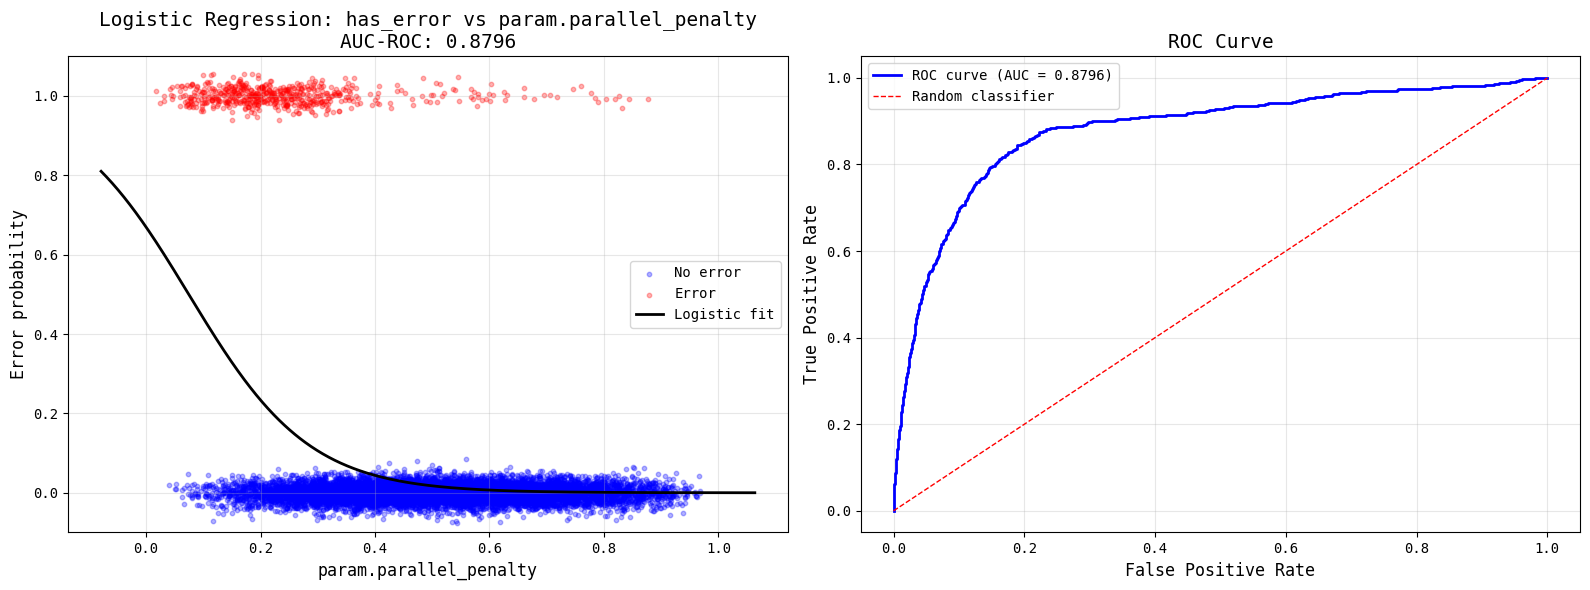

Prediction statistics:
  Mean parallel_penalty (no error): 0.512492
  Mean parallel_penalty (error): 0.245094
  Median parallel_penalty (no error): 0.509932
  Median parallel_penalty (error): 0.214471


In [ ]:
# Logistic classifier to predict has_error based on parallel_penalty
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, roc_curve

# Try to find the columns
has_error_col = None
parallel_penalty_col = None

# Try different variations
for col in df.columns:
    col_lower = col.lower()
    if 'has_error' in col_lower or col == 'has_error':
        has_error_col = col
    if 'parallel_penalty' in col_lower:
        parallel_penalty_col = col

# Also try param.* versions
if parallel_penalty_col is None:
    if 'param.parallel_penalty' in df.columns:
        parallel_penalty_col = 'param.parallel_penalty'

print(f"has_error column: {has_error_col}")
print(f"parallel_penalty column: {parallel_penalty_col}")
print()

if has_error_col is None or parallel_penalty_col is None:
    if has_error_col is None:
        print("Error: has_error column not found")
        print("Available columns containing 'error':", [c for c in df.columns if 'error' in c.lower()][:10])
    if parallel_penalty_col is None:
        print("Error: parallel_penalty column not found")
        print("Available columns containing 'parallel':", [c for c in df.columns if 'parallel' in c.lower()][:10])
else:
    # Prepare data
    # Get rows where both columns are non-NaN
    mask = df[has_error_col].notna() & df[parallel_penalty_col].notna()
    
    X = df.loc[mask, parallel_penalty_col].values.reshape(-1, 1)
    y = df.loc[mask, has_error_col].values
    
    # Convert y to binary if needed (handle boolean, int, or string)
    if y.dtype == bool:
        y = y.astype(int)
    elif y.dtype == object:
        # Try to convert string/object to numeric
        y = pd.to_numeric(y, errors='coerce')
        mask = mask & pd.notna(y)
        X = df.loc[mask, parallel_penalty_col].values.reshape(-1, 1)
        y = df.loc[mask, has_error_col].values
        y = pd.to_numeric(y, errors='coerce').fillna(0).astype(int)
    
    print(f"Data points: {len(X):,}")
    print(f"  Errors (y=1): {(y == 1).sum():,} ({(y == 1).sum() / len(y):.2%})")
    print(f"  No errors (y=0): {(y == 0).sum():,} ({(y == 0).sum() / len(y):.2%})")
    print()
    
    if len(X) > 0:
        # Fit logistic regression
        model = LogisticRegression()
        model.fit(X, y)
        
        # Get predictions
        y_pred_proba = model.predict_proba(X)[:, 1]
        y_pred = model.predict(X)
        
        # Calculate AUC
        auc = roc_auc_score(y, y_pred_proba)
        print(f"Model performance:")
        print(f"  AUC-ROC: {auc:.4f}")
        print(f"  Coefficients: intercept={model.intercept_[0]:.4f}, coef={model.coef_[0][0]:.4f}")
        print()
        
        # Create prediction curve
        x_min = X.min()
        x_max = X.max()
        x_range = x_max - x_min
        x_plot = np.linspace(x_min - 0.1 * x_range, x_max + 0.1 * x_range, 1000).reshape(-1, 1)
        y_plot_proba = model.predict_proba(x_plot)[:, 1]
        
        # Plot
        fig, axes = plt.subplots(1, 2, figsize=(16, 6))
        
        # Left plot: Scatter with fitted curve
        ax1 = axes[0]
        # Plot data points (jittered for visibility)
        y_jitter = y + np.random.normal(0, 0.02, len(y))
        ax1.scatter(X[y == 0], y_jitter[y == 0], alpha=0.3, s=10, color='blue', label='No error')
        ax1.scatter(X[y == 1], y_jitter[y == 1], alpha=0.3, s=10, color='red', label='Error')
        ax1.plot(x_plot, y_plot_proba, 'k-', linewidth=2, label='Logistic fit')
        ax1.set_xlabel(parallel_penalty_col, fontsize=12)
        ax1.set_ylabel('Error probability', fontsize=12)
        ax1.set_title(f'Logistic Regression: has_error vs {parallel_penalty_col}\nAUC-ROC: {auc:.4f}', fontsize=14)
        ax1.legend()
        ax1.grid(True, alpha=0.3)
        ax1.set_ylim(-0.1, 1.1)
        
        # Right plot: ROC curve
        ax2 = axes[1]
        fpr, tpr, thresholds = roc_curve(y, y_pred_proba)
        ax2.plot(fpr, tpr, 'b-', linewidth=2, label=f'ROC curve (AUC = {auc:.4f})')
        ax2.plot([0, 1], [0, 1], 'r--', linewidth=1, label='Random classifier')
        ax2.set_xlabel('False Positive Rate', fontsize=12)
        ax2.set_ylabel('True Positive Rate', fontsize=12)
        ax2.set_title('ROC Curve', fontsize=14)
        ax2.legend()
        ax2.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
        
        # Print some statistics
        print("Prediction statistics:")
        print(f"  Mean parallel_penalty (no error): {X[y == 0].mean():.6f}")
        print(f"  Mean parallel_penalty (error): {X[y == 1].mean():.6f}")
        print(f"  Median parallel_penalty (no error): {np.median(X[y == 0]):.6f}")
        print(f"  Median parallel_penalty (error): {np.median(X[y == 1]):.6f}")
    else:
        print("No data points with both columns non-NaN")


has_error column: has_error
parallel_penalty column: param.parallel_penalty
coding_automation_efficiency_slope column: param.coding_automation_efficiency_slope

=== Coding Automation Efficiency Slope Classifier ===
Data points: 10,000
  Errors (y=1): 564 (5.64%)
  No errors (y=0): 9,436 (94.36%)

Model performance (coding_automation_efficiency_slope):
  AUC-ROC: 0.8151
  Coefficients: intercept=-4.2943, coef=0.3847



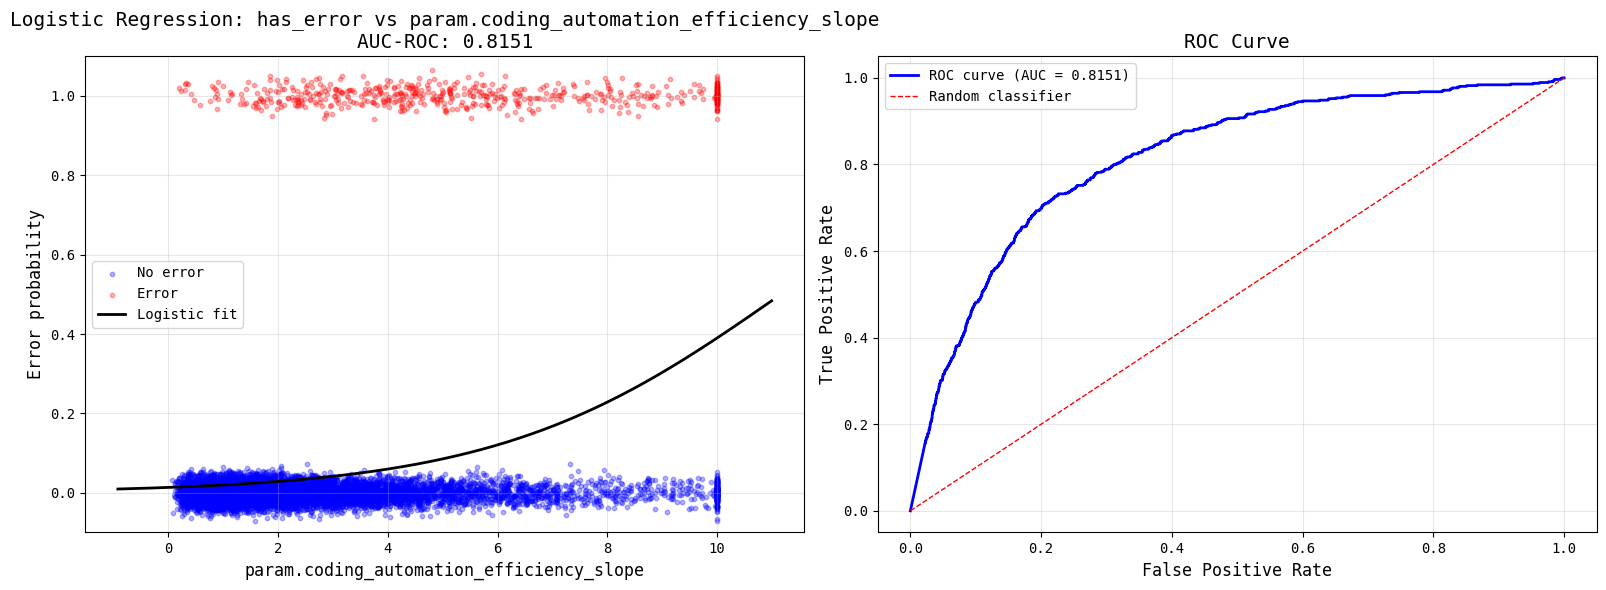

Prediction statistics (coding_automation_efficiency_slope):
  Mean (no error): 2.553595
  Mean (error): 5.582992
  Median (no error): 1.896610
  Median (error): 5.134222

=== Joint Classifier (parallel_penalty + coding_automation_efficiency_slope) ===
Data points: 10,000
  Errors (y=1): 564 (5.64%)
  No errors (y=0): 9,436 (94.36%)

Model performance (joint):
  AUC-ROC: 0.9221
  Coefficients:
    Intercept: -0.6425
    param.parallel_penalty: -11.6000
    param.coding_automation_efficiency_slope: 0.5238



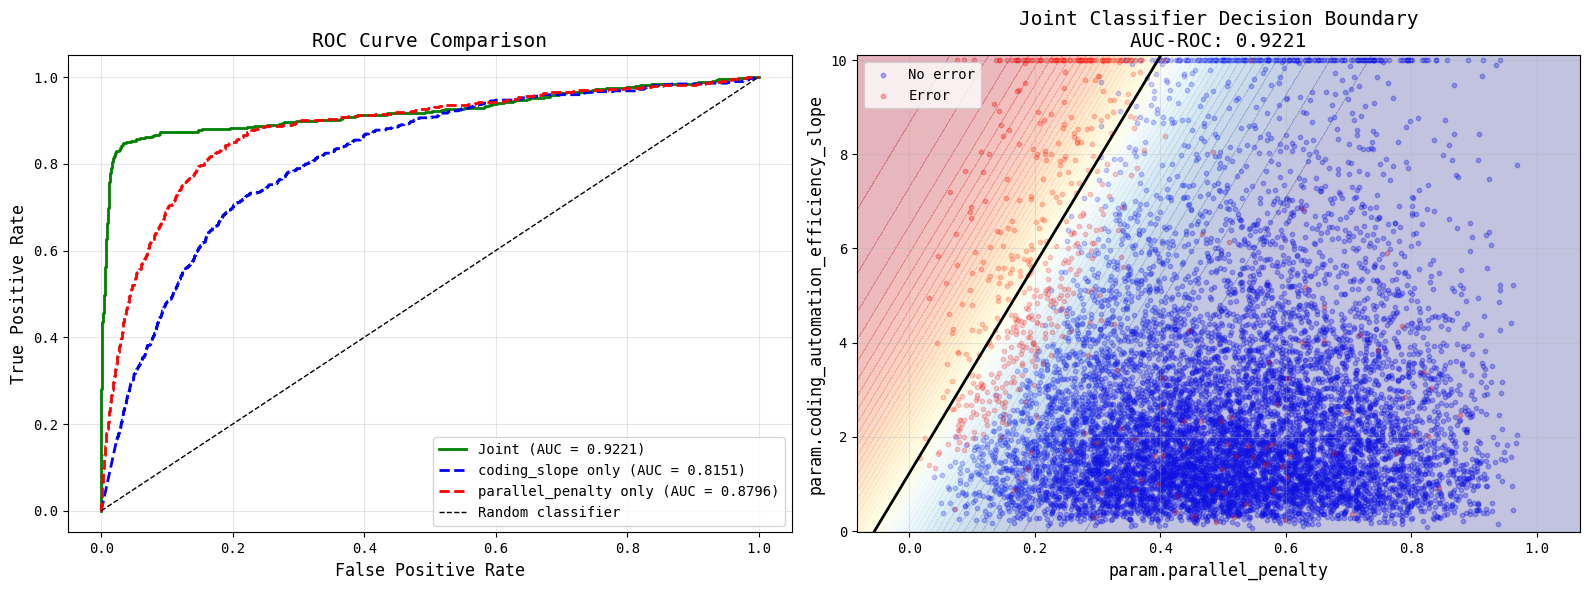

Comparison of AUC scores:
  parallel_penalty only: 0.8796
  coding_automation_efficiency_slope only: 0.8150590465367282
  Joint (both): 0.9221
  Improvement: 0.0425


In [ ]:
# Logistic classifier for coding_automation_efficiency_slope and joint classifier
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, roc_curve
import pandas as pd

# Try to find the columns
has_error_col = None
parallel_penalty_col = None
coding_slope_col = None

# Try different variations
for col in df.columns:
    col_lower = col.lower()
    if 'has_error' in col_lower or col == 'has_error':
        has_error_col = col
    if 'parallel_penalty' in col_lower:
        parallel_penalty_col = col
    if 'coding_automation_efficiency_slope' in col_lower:
        coding_slope_col = col

# Also try param.* versions
if parallel_penalty_col is None:
    if 'param.parallel_penalty' in df.columns:
        parallel_penalty_col = 'param.parallel_penalty'
if coding_slope_col is None:
    if 'param.coding_automation_efficiency_slope' in df.columns:
        coding_slope_col = 'param.coding_automation_efficiency_slope'

print(f"has_error column: {has_error_col}")
print(f"parallel_penalty column: {parallel_penalty_col}")
print(f"coding_automation_efficiency_slope column: {coding_slope_col}")
print()

if has_error_col is None:
    print("Error: has_error column not found")
    print("Available columns containing 'error':", [c for c in df.columns if 'error' in c.lower()][:10])
elif coding_slope_col is None:
    print("Error: coding_automation_efficiency_slope column not found")
    print("Available columns containing 'coding':", [c for c in df.columns if 'coding' in c.lower()][:10])
else:
    # Prepare data for coding_automation_efficiency_slope
    mask_slope = df[has_error_col].notna() & df[coding_slope_col].notna()
    
    X_slope = df.loc[mask_slope, coding_slope_col].values.reshape(-1, 1)
    y_slope = df.loc[mask_slope, has_error_col].values
    
    # Convert y to binary if needed
    if y_slope.dtype == bool:
        y_slope = y_slope.astype(int)
    elif y_slope.dtype == object:
        y_slope = pd.to_numeric(y_slope, errors='coerce').fillna(0).astype(int)
        mask_slope = mask_slope & pd.notna(pd.to_numeric(df[has_error_col], errors='coerce'))
        X_slope = df.loc[mask_slope, coding_slope_col].values.reshape(-1, 1)
        y_slope = df.loc[mask_slope, has_error_col].values
        y_slope = pd.to_numeric(y_slope, errors='coerce').fillna(0).astype(int)
    
    print(f"=== Coding Automation Efficiency Slope Classifier ===")
    print(f"Data points: {len(X_slope):,}")
    print(f"  Errors (y=1): {(y_slope == 1).sum():,} ({(y_slope == 1).sum() / len(y_slope):.2%})")
    print(f"  No errors (y=0): {(y_slope == 0).sum():,} ({(y_slope == 0).sum() / len(y_slope):.2%})")
    print()
    
    if len(X_slope) > 0:
        # Fit logistic regression for coding_automation_efficiency_slope
        model_slope = LogisticRegression()
        model_slope.fit(X_slope, y_slope)
        
        y_pred_proba_slope = model_slope.predict_proba(X_slope)[:, 1]
        auc_slope = roc_auc_score(y_slope, y_pred_proba_slope)
        
        print(f"Model performance (coding_automation_efficiency_slope):")
        print(f"  AUC-ROC: {auc_slope:.4f}")
        print(f"  Coefficients: intercept={model_slope.intercept_[0]:.4f}, coef={model_slope.coef_[0][0]:.4f}")
        print()
        
        # Create prediction curve
        x_min_slope = X_slope.min()
        x_max_slope = X_slope.max()
        x_range_slope = x_max_slope - x_min_slope
        x_plot_slope = np.linspace(x_min_slope - 0.1 * x_range_slope, 
                                   x_max_slope + 0.1 * x_range_slope, 1000).reshape(-1, 1)
        y_plot_proba_slope = model_slope.predict_proba(x_plot_slope)[:, 1]
        
        # Plot for coding_automation_efficiency_slope
        fig, axes = plt.subplots(1, 2, figsize=(16, 6))
        
        # Left plot: Scatter with fitted curve
        ax1 = axes[0]
        y_jitter_slope = y_slope + np.random.normal(0, 0.02, len(y_slope))
        ax1.scatter(X_slope[y_slope == 0], y_jitter_slope[y_slope == 0], alpha=0.3, s=10, 
                   color='blue', label='No error')
        ax1.scatter(X_slope[y_slope == 1], y_jitter_slope[y_slope == 1], alpha=0.3, s=10, 
                   color='red', label='Error')
        ax1.plot(x_plot_slope, y_plot_proba_slope, 'k-', linewidth=2, label='Logistic fit')
        ax1.set_xlabel(coding_slope_col, fontsize=12)
        ax1.set_ylabel('Error probability', fontsize=12)
        ax1.set_title(f'Logistic Regression: has_error vs {coding_slope_col}\nAUC-ROC: {auc_slope:.4f}', fontsize=14)
        ax1.legend()
        ax1.grid(True, alpha=0.3)
        ax1.set_ylim(-0.1, 1.1)
        
        # Right plot: ROC curve
        ax2 = axes[1]
        fpr_slope, tpr_slope, _ = roc_curve(y_slope, y_pred_proba_slope)
        ax2.plot(fpr_slope, tpr_slope, 'b-', linewidth=2, label=f'ROC curve (AUC = {auc_slope:.4f})')
        ax2.plot([0, 1], [0, 1], 'r--', linewidth=1, label='Random classifier')
        ax2.set_xlabel('False Positive Rate', fontsize=12)
        ax2.set_ylabel('True Positive Rate', fontsize=12)
        ax2.set_title('ROC Curve', fontsize=14)
        ax2.legend()
        ax2.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
        
        print("Prediction statistics (coding_automation_efficiency_slope):")
        print(f"  Mean (no error): {X_slope[y_slope == 0].mean():.6f}")
        print(f"  Mean (error): {X_slope[y_slope == 1].mean():.6f}")
        print(f"  Median (no error): {np.median(X_slope[y_slope == 0]):.6f}")
        print(f"  Median (error): {np.median(X_slope[y_slope == 1]):.6f}")
        print()
    
    # Joint classifier
    if parallel_penalty_col is not None:
        print(f"=== Joint Classifier (parallel_penalty + coding_automation_efficiency_slope) ===")
        
        # Prepare joint data
        mask_joint = (df[has_error_col].notna() & 
                     df[parallel_penalty_col].notna() & 
                     df[coding_slope_col].notna())
        
        X_joint = df.loc[mask_joint, [parallel_penalty_col, coding_slope_col]].values
        y_joint = df.loc[mask_joint, has_error_col].values
        
        # Convert y to binary if needed
        if y_joint.dtype == bool:
            y_joint = y_joint.astype(int)
        elif y_joint.dtype == object:
            y_joint = pd.to_numeric(y_joint, errors='coerce').fillna(0).astype(int)
        
        print(f"Data points: {len(X_joint):,}")
        print(f"  Errors (y=1): {(y_joint == 1).sum():,} ({(y_joint == 1).sum() / len(y_joint):.2%})")
        print(f"  No errors (y=0): {(y_joint == 0).sum():,} ({(y_joint == 0).sum() / len(y_joint):.2%})")
        print()
        
        if len(X_joint) > 0:
            # Fit joint logistic regression
            model_joint = LogisticRegression()
            model_joint.fit(X_joint, y_joint)
            
            y_pred_proba_joint = model_joint.predict_proba(X_joint)[:, 1]
            auc_joint = roc_auc_score(y_joint, y_pred_proba_joint)
            
            print(f"Model performance (joint):")
            print(f"  AUC-ROC: {auc_joint:.4f}")
            print(f"  Coefficients:")
            print(f"    Intercept: {model_joint.intercept_[0]:.4f}")
            print(f"    {parallel_penalty_col}: {model_joint.coef_[0][0]:.4f}")
            print(f"    {coding_slope_col}: {model_joint.coef_[0][1]:.4f}")
            print()
            
            # Plot joint classifier results
            fig, axes = plt.subplots(1, 2, figsize=(16, 6))
            
            # Left plot: ROC curve comparison
            ax1 = axes[0]
            fpr_joint, tpr_joint, _ = roc_curve(y_joint, y_pred_proba_joint)
            ax1.plot(fpr_joint, tpr_joint, 'g-', linewidth=2, 
                    label=f'Joint (AUC = {auc_joint:.4f})')
            
            # Also plot individual ROC curves if we have the data
            if len(X_slope) > 0 and len(mask_slope) == len(mask_joint):
                # Use same subset for fair comparison
                mask_common = mask_joint
                X_slope_subset = df.loc[mask_common, coding_slope_col].values.reshape(-1, 1)
                y_common = df.loc[mask_common, has_error_col].values
                if y_common.dtype == bool:
                    y_common = y_common.astype(int)
                elif y_common.dtype == object:
                    y_common = pd.to_numeric(y_common, errors='coerce').fillna(0).astype(int)
                
                model_slope_subset = LogisticRegression()
                model_slope_subset.fit(X_slope_subset, y_common)
                y_pred_proba_slope_subset = model_slope_subset.predict_proba(X_slope_subset)[:, 1]
                auc_slope_subset = roc_auc_score(y_common, y_pred_proba_slope_subset)
                fpr_slope_subset, tpr_slope_subset, _ = roc_curve(y_common, y_pred_proba_slope_subset)
                ax1.plot(fpr_slope_subset, tpr_slope_subset, 'b--', linewidth=2,
                        label=f'coding_slope only (AUC = {auc_slope_subset:.4f})')
            
            if parallel_penalty_col:
                X_penalty_subset = df.loc[mask_joint, parallel_penalty_col].values.reshape(-1, 1)
                model_penalty_subset = LogisticRegression()
                model_penalty_subset.fit(X_penalty_subset, y_joint)
                y_pred_proba_penalty_subset = model_penalty_subset.predict_proba(X_penalty_subset)[:, 1]
                auc_penalty_subset = roc_auc_score(y_joint, y_pred_proba_penalty_subset)
                fpr_penalty_subset, tpr_penalty_subset, _ = roc_curve(y_joint, y_pred_proba_penalty_subset)
                ax1.plot(fpr_penalty_subset, tpr_penalty_subset, 'r--', linewidth=2,
                        label=f'parallel_penalty only (AUC = {auc_penalty_subset:.4f})')
            
            ax1.plot([0, 1], [0, 1], 'k--', linewidth=1, label='Random classifier')
            ax1.set_xlabel('False Positive Rate', fontsize=12)
            ax1.set_ylabel('True Positive Rate', fontsize=12)
            ax1.set_title('ROC Curve Comparison', fontsize=14)
            ax1.legend()
            ax1.grid(True, alpha=0.3)
            
            # Right plot: 2D scatter with decision boundary
            ax2 = axes[1]
            scatter1 = ax2.scatter(X_joint[y_joint == 0, 0], X_joint[y_joint == 0, 1], 
                                  alpha=0.3, s=10, color='blue', label='No error')
            scatter2 = ax2.scatter(X_joint[y_joint == 1, 0], X_joint[y_joint == 1, 1], 
                                  alpha=0.3, s=10, color='red', label='Error')
            
            # Create mesh for decision boundary
            x1_min, x1_max = X_joint[:, 0].min() - 0.1, X_joint[:, 0].max() + 0.1
            x2_min, x2_max = X_joint[:, 1].min() - 0.1, X_joint[:, 1].max() + 0.1
            xx1, xx2 = np.meshgrid(np.linspace(x1_min, x1_max, 100),
                                  np.linspace(x2_min, x2_max, 100))
            Z = model_joint.predict_proba(np.c_[xx1.ravel(), xx2.ravel()])[:, 1]
            Z = Z.reshape(xx1.shape)
            
            contour = ax2.contour(xx1, xx2, Z, levels=[0.5], colors='black', linewidths=2)
            ax2.contourf(xx1, xx2, Z, levels=50, alpha=0.3, cmap='RdYlBu_r')
            
            ax2.set_xlabel(parallel_penalty_col, fontsize=12)
            ax2.set_ylabel(coding_slope_col, fontsize=12)
            ax2.set_title(f'Joint Classifier Decision Boundary\nAUC-ROC: {auc_joint:.4f}', fontsize=14)
            ax2.legend()
            ax2.grid(True, alpha=0.3)
            
            plt.tight_layout()
            plt.show()
            
            print("Comparison of AUC scores:")
            if parallel_penalty_col:
                print(f"  parallel_penalty only: {auc_penalty_subset:.4f}")
            print(f"  coding_automation_efficiency_slope only: {auc_slope_subset if 'auc_slope_subset' in locals() else 'N/A'}")
            print(f"  Joint (both): {auc_joint:.4f}")
            print(f"  Improvement: {auc_joint - max(auc_penalty_subset if parallel_penalty_col else 0, auc_slope_subset if 'auc_slope_subset' in locals() else 0):.4f}")
        else:
            print("No data points with all three columns non-NaN")
    else:
        print("parallel_penalty column not found, skipping joint classifier")


In [ ]:
# Calculate fraction of total errors in classifier-identified region
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression

# Find columns (reuse from previous cell logic)
has_error_col = None
parallel_penalty_col = None
coding_slope_col = None

for col in df.columns:
    col_lower = col.lower()
    if 'has_error' in col_lower or col == 'has_error':
        has_error_col = col
    if 'parallel_penalty' in col_lower:
        parallel_penalty_col = col
    if 'coding_automation_efficiency_slope' in col_lower:
        coding_slope_col = col

if parallel_penalty_col is None:
    if 'param.parallel_penalty' in df.columns:
        parallel_penalty_col = 'param.parallel_penalty'
if coding_slope_col is None:
    if 'param.coding_automation_efficiency_slope' in df.columns:
        coding_slope_col = 'param.coding_automation_efficiency_slope'

if has_error_col is None or parallel_penalty_col is None or coding_slope_col is None:
    print("Error: Required columns not found")
else:
    # Prepare joint data (same as before)
    mask_joint = (df[has_error_col].notna() & 
                 df[parallel_penalty_col].notna() & 
                 df[coding_slope_col].notna())
    
    X_joint = df.loc[mask_joint, [parallel_penalty_col, coding_slope_col]].values
    y_joint = df.loc[mask_joint, has_error_col].values
    
    # Convert y to binary if needed
    if y_joint.dtype == bool:
        y_joint = y_joint.astype(int)
    elif y_joint.dtype == object:
        y_joint = pd.to_numeric(y_joint, errors='coerce').fillna(0).astype(int)
    
    if len(X_joint) > 0:
        # Fit joint logistic regression
        model_joint = LogisticRegression()
        model_joint.fit(X_joint, y_joint)
        
        # Get predictions (error region = predicted probability > 0.5)
        y_pred_proba = model_joint.predict_proba(X_joint)[:, 1]
        y_pred = model_joint.predict(X_joint)
        
        # Calculate statistics
        total_errors = (y_joint == 1).sum()
        errors_in_predicted_region = ((y_joint == 1) & (y_pred == 1)).sum()
        fraction_errors_in_region = errors_in_predicted_region / total_errors if total_errors > 0 else 0
        
        # Also calculate using different thresholds
        thresholds = [0.3, 0.4, 0.5, 0.6, 0.7]
        
        print("Fraction of total errors in classifier-identified region:")
        print("=" * 80)
        print(f"{'Threshold':<15} {'Predicted Region Size':<25} {'Errors in Region':<20} {'Fraction of Total Errors':<25}")
        print("-" * 80)
        
        for threshold in thresholds:
            predicted_region = y_pred_proba >= threshold
            region_size = predicted_region.sum()
            errors_in_region = ((y_joint == 1) & predicted_region).sum()
            fraction = errors_in_region / total_errors if total_errors > 0 else 0
            
            print(f"{threshold:<15.2f} {region_size:>25,} {errors_in_region:>20,} {fraction:>25.2%}")
        
        print("-" * 80)
        print()
        print(f"Using default threshold (0.5):")
        print(f"  Total errors: {total_errors:,}")
        print(f"  Errors in predicted error region: {errors_in_predicted_region:,}")
        print(f"  Fraction of total errors in region: {fraction_errors_in_region:.2%}")
        print()
        
        # Also calculate precision and recall
        true_positives = ((y_joint == 1) & (y_pred == 1)).sum()
        false_positives = ((y_joint == 0) & (y_pred == 1)).sum()
        false_negatives = ((y_joint == 1) & (y_pred == 0)).sum()
        
        precision = true_positives / (true_positives + false_positives) if (true_positives + false_positives) > 0 else 0
        recall = true_positives / (true_positives + false_negatives) if (true_positives + false_negatives) > 0 else 0
        
        print(f"Classification metrics (threshold = 0.5):")
        print(f"  Precision (of predicted errors, how many are actually errors): {precision:.2%}")
        print(f"  Recall (of actual errors, how many are predicted): {recall:.2%}")
        print(f"  F1 score: {2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0:.4f}")
    else:
        print("No data points with all required columns non-NaN")


Fraction of total errors in classifier-identified region:
Threshold       Predicted Region Size     Errors in Region     Fraction of Total Errors 
--------------------------------------------------------------------------------
0.30                                  537                  422                    74.82%
0.40                                  377                  317                    56.21%
0.50                                  260                  243                    43.09%
0.60                                  196                  187                    33.16%
0.70                                  132                  131                    23.23%
--------------------------------------------------------------------------------

Using default threshold (0.5):
  Total errors: 564
  Errors in predicted error region: 243
  Fraction of total errors in region: 43.09%

Classification metrics (threshold = 0.5):
  Precision (of predicted errors, how many are actually errors): 9

Column: param.coding_automation_efficiency_slope
Total non-NaN values: 10,000

Statistics:
  Min: 0.071527
  25th percentile: 1.119731
  50th percentile (median): 1.989098
  75th percentile: 3.546441
  99th percentile: 10.000000
  Max: 10.000000
  Mean: 2.724453
  Std: 2.275247


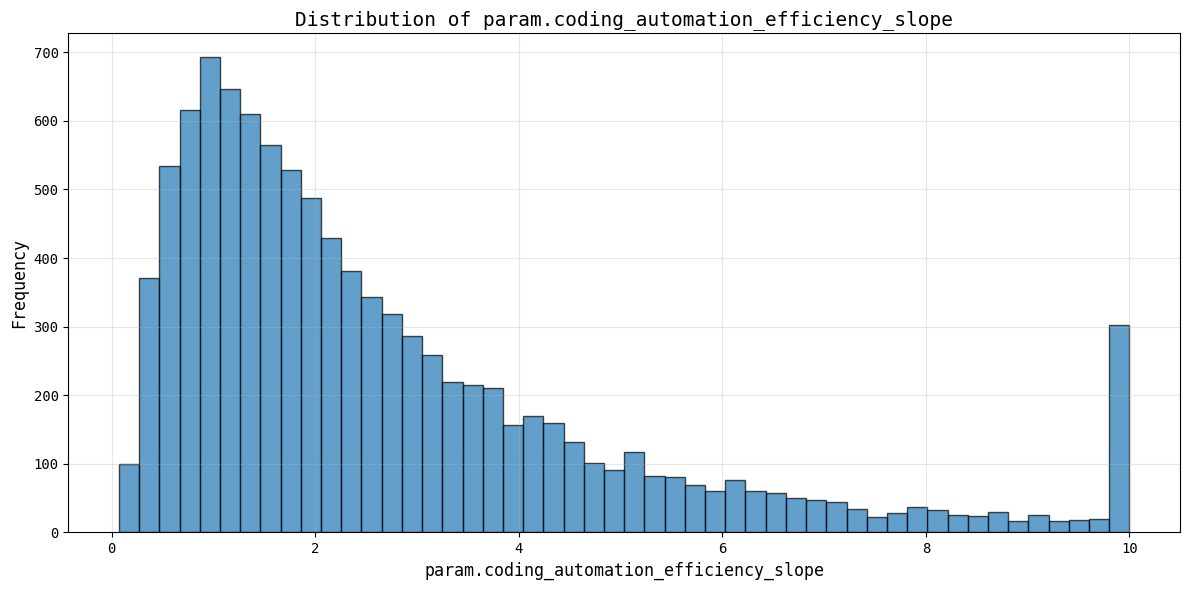

In [ ]:
# Histogram of coding_automation_efficiency_slope values
import numpy as np
import matplotlib.pyplot as plt

# Try to find the column
col_candidates = [
    'param.coding_automation_efficiency_slope',
    'coding_automation_efficiency_slope',
    'coding_automation_efficiency_slope_at_reference_year'
]

col_name = None
for candidate in col_candidates:
    if candidate in df.columns:
        col_name = candidate
        break

if col_name is None:
    print("Column not found. Available columns containing 'coding':")
    print([c for c in df.columns if 'coding' in c.lower()][:20])
else:
    values = df[col_name].dropna()
    
    if len(values) > 0:
        print(f"Column: {col_name}")
        print(f"Total non-NaN values: {len(values):,}")
        print()
        print("Statistics:")
        print(f"  Min: {values.min():.6f}")
        print(f"  25th percentile: {values.quantile(0.25):.6f}")
        print(f"  50th percentile (median): {values.quantile(0.50):.6f}")
        print(f"  75th percentile: {values.quantile(0.75):.6f}")
        print(f"  99th percentile: {values.quantile(0.99):.6f}")
        print(f"  Max: {values.max():.6f}")
        print(f"  Mean: {values.mean():.6f}")
        print(f"  Std: {values.std():.6f}")
        
        # Plot histogram
        plt.figure(figsize=(12, 6))
        plt.hist(values, bins=50, edgecolor='black', alpha=0.7)
        plt.xlabel(col_name, fontsize=12)
        plt.ylabel('Frequency', fontsize=12)
        plt.title(f'Distribution of {col_name}', fontsize=14)
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()
    else:
        print(f"No non-NaN values found for {col_name}")


In [ ]:
# Generalized function to stratify by slope_times_log_f * r_software and analyze milestone achievement
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def analyze_milestone_stratification(df, milestone1_name, milestone2_name, 
                                     col1='slope_times_log_f', col2='r_software', 
                                     n_strata=20):
    """
    Stratify by col1 * col2 and analyze milestone1 achievement relative to milestone2.
    
    Parameters:
    -----------
    df : pandas.DataFrame
        The dataframe containing the data
    milestone1_name : str
        Name of the first milestone (e.g., 'ASI', 'AC')
    milestone2_name : str
        Name of the second milestone (e.g., 'SAR', 'AC')
    col1 : str
        First column name for stratification product (default: 'slope_times_log_f')
    col2 : str
        Second column name for stratification product (default: 'r_software')
    n_strata : int
        Number of strata to create (default: 20)
    
    Returns:
    --------
    results : list
        List of dictionaries containing stratum analysis results
    """
    # Find columns
    milestone1_col = f'milestone.{milestone1_name}.time'
    milestone2_col = f'milestone.{milestone2_name}.time'
    
    # Try param.* versions if needed
    col1_actual = col1
    col2_actual = col2
    if col1 not in df.columns:
        param_col1 = f'param.{col1}'
        if param_col1 in df.columns:
            col1_actual = param_col1
    if col2 not in df.columns:
        param_col2 = f'param.{col2}'
        if param_col2 in df.columns:
            col2_actual = param_col2
    
    print(f"Using columns:")
    print(f"  {col1_actual}")
    print(f"  {col2_actual}")
    print(f"  {milestone1_col}")
    print(f"  {milestone2_col}")
    print()
    
    if col1_actual not in df.columns or col2_actual not in df.columns or \
       milestone1_col not in df.columns or milestone2_col not in df.columns:
        missing_cols = []
        if col1_actual not in df.columns:
            missing_cols.append(col1_actual)
        if col2_actual not in df.columns:
            missing_cols.append(col2_actual)
        if milestone1_col not in df.columns:
            missing_cols.append(milestone1_col)
        if milestone2_col not in df.columns:
            missing_cols.append(milestone2_col)
        print(f"Error: Missing columns: {missing_cols}")
        return None
    
    # Show filtering diagnostics
    total_runs = len(df)
    col1_non_nan = df[col1_actual].notna().sum()
    col2_non_nan = df[col2_actual].notna().sum()
    both_non_nan = df[col1_actual].notna() & df[col2_actual].notna()
    both_non_nan_count = both_non_nan.sum()
    
    print("Filtering diagnostics:")
    print(f"  Total runs in dataframe: {total_runs:,}")
    print(f"  Runs with {col1_actual} non-NaN: {col1_non_nan:,} ({col1_non_nan/total_runs:.2%})")
    print(f"  Runs with {col2_actual} non-NaN: {col2_non_nan:,} ({col2_non_nan/total_runs:.2%})")
    print(f"  Runs with both non-NaN: {both_non_nan_count:,} ({both_non_nan_count/total_runs:.2%})")
    print(f"  Runs excluded from stratification: {total_runs - both_non_nan_count:,} ({(total_runs - both_non_nan_count)/total_runs:.2%})")
    print()
    
    # Calculate product
    product = df.loc[both_non_nan, col1_actual] * df.loc[both_non_nan, col2_actual]
    
    # Create strata (bins) - use quantiles or fixed bins
    # Use quantile-based bins for more balanced groups
    quantiles = np.linspace(0, 1, n_strata + 1)
    bin_edges = product.quantile(quantiles).values
    
    # Create stratum labels
    stratum_labels = []
    for i in range(len(bin_edges) - 1):
        stratum_labels.append(f"Q{int(quantiles[i]*100)}-Q{int(quantiles[i+1]*100)}")
    
    # Assign strata
    stratum_indices = pd.cut(product, bins=bin_edges, labels=stratum_labels, include_lowest=True)
    
    # Analyze each stratum
    results = []
    
    for stratum_label in stratum_labels:
        stratum_mask = (stratum_indices == stratum_label) & both_non_nan
        stratum_df = df.loc[stratum_mask]
        
        total_runs = len(stratum_df)
        
        # Check milestone achievement
        milestone1_achieved = stratum_df[milestone1_col].notna()
        milestone2_achieved = stratum_df[milestone2_col].notna()
        
        # Calculate milestone1 - milestone2 time difference for runs where both are achieved
        both_achieved = milestone1_achieved & milestone2_achieved
        if both_achieved.sum() > 0:
            time_diff = stratum_df.loc[both_achieved, milestone1_col] - stratum_df.loc[both_achieved, milestone2_col]
            median_diff = time_diff.median()
            mean_diff = time_diff.mean()
            p25_diff = time_diff.quantile(0.25)
            p75_diff = time_diff.quantile(0.75)
        else:
            median_diff = np.nan
            mean_diff = np.nan
            p25_diff = np.nan
            p75_diff = np.nan
        
        fraction_milestone1 = milestone1_achieved.sum() / total_runs if total_runs > 0 else 0
        
        # Calculate runs where only milestone2 is achieved (not milestone1)
        only_milestone2 = milestone2_achieved & ~milestone1_achieved
        only_milestone2_count = only_milestone2.sum()
        fraction_only_milestone2 = only_milestone2_count / total_runs if total_runs > 0 else 0
        fraction_both = both_achieved.sum() / total_runs if total_runs > 0 else 0
        
        # Get product range for this stratum
        product_stratum = product[stratum_mask]
        product_min = product_stratum.min()
        product_max = product_stratum.max()
        product_median = product_stratum.median()
        
        results.append({
            'stratum': stratum_label,
            'total_runs': total_runs,
            'milestone1_achieved': milestone1_achieved.sum(),
            'fraction_milestone1': fraction_milestone1,
            'only_milestone2_count': only_milestone2_count,
            'fraction_only_milestone2': fraction_only_milestone2,
            'fraction_both': fraction_both,
            'both_achieved': both_achieved.sum(),
            'median_diff': median_diff,
            'mean_diff': mean_diff,
            'p25_diff': p25_diff,
            'p75_diff': p75_diff,
            'product_min': product_min,
            'product_max': product_max,
            'product_median': product_median
        })
    
    # Print results table
    print(f"Stratification by {col1_actual} * {col2_actual} ({milestone1_name} vs {milestone2_name}):")
    print("=" * 140)
    print(f"{'Stratum':<15} {'Total':>10} {f'{milestone1_name} Achieved':>20} {'Fraction':>12} {'Both Achieved':>15} "
          f"{'Median Diff':>15} {'Mean Diff':>15} {'P25 Diff':>15} {'P75 Diff':>15} {'Product Range':>30}")
    print("-" * 140)
    
    for r in results:
        product_range_str = f"[{r['product_min']:.3f}, {r['product_max']:.3f}]"
        median_str = f"{r['median_diff']:.2f}" if not np.isnan(r['median_diff']) else "N/A"
        mean_str = f"{r['mean_diff']:.2f}" if not np.isnan(r['mean_diff']) else "N/A"
        p25_str = f"{r['p25_diff']:.2f}" if not np.isnan(r['p25_diff']) else "N/A"
        p75_str = f"{r['p75_diff']:.2f}" if not np.isnan(r['p75_diff']) else "N/A"
        
        print(f"{r['stratum']:<15} {r['total_runs']:>10,} {r['milestone1_achieved']:>20,} {r['fraction_milestone1']:>12.2%} "
              f"{r['both_achieved']:>15,} {median_str:>15} {mean_str:>15} {p25_str:>15} {p75_str:>15} "
              f"{product_range_str:>30}")
    
    print("-" * 140)
    
    # Verify strata sum correctly
    total_in_strata = sum(r['total_runs'] for r in results)
    print()
    print(f"Verification:")
    print(f"  Total runs in strata: {total_in_strata:,}")
    print(f"  Expected (both columns non-NaN): {both_non_nan_count:,}")
    print(f"  Match: {'✓' if total_in_strata == both_non_nan_count else '✗'}")
    print()
    
    # Create visualizations
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    
    # Extract data for plotting
    strata = [r['stratum'] for r in results]
    fractions = [r['fraction_milestone1'] for r in results]
    fractions_only_milestone2 = [r['fraction_only_milestone2'] for r in results]
    fractions_both = [r['fraction_both'] for r in results]
    median_diffs = [r['median_diff'] if not np.isnan(r['median_diff']) else None for r in results]
    product_medians = [r['product_median'] for r in results]
    
    # Plot 1: Stacked bars showing only milestone2 and both milestones
    ax1 = axes[0, 0]
    x_pos = range(len(strata))
    ax1.bar(x_pos, fractions_only_milestone2, edgecolor='black', alpha=0.7, 
            label=f'Only {milestone2_name}', color='lightblue')
    ax1.bar(x_pos, fractions_both, bottom=fractions_only_milestone2, 
            edgecolor='black', alpha=0.7, label=f'Both {milestone1_name} and {milestone2_name}', 
            color='steelblue')
    ax1.set_xticks(x_pos)
    ax1.set_xticklabels(strata, rotation=45, ha='right')
    ax1.set_ylabel(f'Fraction Achieving {milestone1_name}', fontsize=12)
    ax1.set_xlabel(f'Stratum (by {col1_actual} * {col2_actual})', fontsize=12)
    ax1.set_title(f'Fraction of Runs Achieving {milestone1_name} by Stratum', fontsize=14)
    ax1.grid(True, alpha=0.3, axis='y')
    ax1.set_ylim(0, 1)
    ax1.legend(loc='upper left', fontsize=10)
    
    # Plot 2: Median milestone1-milestone2 time difference by stratum
    ax2 = axes[0, 1]
    valid_median_diffs = [d for d in median_diffs if d is not None]
    valid_indices = [i for i, d in enumerate(median_diffs) if d is not None]
    if valid_median_diffs:
        # Filter out non-positive values for log scale
        positive_diffs = [(i, d) for i, d in zip(valid_indices, valid_median_diffs) if d > 0]
        if positive_diffs:
            pos_indices, pos_diffs = zip(*positive_diffs)
            ax2.bar(pos_indices, pos_diffs, edgecolor='black', alpha=0.7)
            ax2.set_yscale('log')
        else:
            ax2.bar(valid_indices, valid_median_diffs, edgecolor='black', alpha=0.7)
        ax2.set_xticks(range(len(strata)))
        ax2.set_xticklabels(strata, rotation=45, ha='right')
        ax2.set_ylabel(f'Median {milestone1_name} - {milestone2_name} Time (years, log scale)', fontsize=12)
        ax2.set_xlabel(f'Stratum (by {col1_actual} * {col2_actual})', fontsize=12)
        ax2.set_title(f'Median Time Difference ({milestone1_name} - {milestone2_name}) by Stratum', fontsize=14)
        ax2.grid(True, alpha=0.3, axis='y')
    
    # Plot 3: Fraction achieving milestone1 vs product median (log x-axis, hide negative)
    ax3 = axes[1, 0]
    # Filter out negative product values
    positive_product_data = [(x, y) for x, y in zip(product_medians, fractions) if x > 0]
    if positive_product_data:
        pos_x3, pos_y3 = zip(*positive_product_data)
        ax3.scatter(pos_x3, pos_y3, s=100, alpha=0.7, edgecolor='black')
        ax3.set_xscale('log')
    else:
        ax3.scatter(product_medians, fractions, s=100, alpha=0.7, edgecolor='black')
    ax3.set_xlabel(f'Median {col1_actual} * {col2_actual} (log scale)', fontsize=12)
    ax3.set_ylabel(f'Fraction Achieving {milestone1_name}', fontsize=12)
    ax3.set_title(f'{milestone1_name} Achievement Rate vs Product Value', fontsize=14)
    ax3.grid(True, alpha=0.3)
    ax3.set_ylim(0, 1)
    
    # Plot 4: Median time difference vs product median with IQR error bars
    ax4 = axes[1, 1]
    valid_product_medians = [product_medians[i] for i in valid_indices]
    p25_diffs = [r['p25_diff'] if not np.isnan(r['p25_diff']) else None for r in results]
    p75_diffs = [r['p75_diff'] if not np.isnan(r['p75_diff']) else None for r in results]
    
    if valid_product_medians:
        # Filter to valid indices and extract corresponding P25/P75
        valid_p25 = [p25_diffs[i] for i in valid_indices]
        valid_p75 = [p75_diffs[i] for i in valid_indices]
        
        # Filter out non-positive values for log scale (both x and y)
        positive_data = []
        for x, y, p25, p75 in zip(valid_product_medians, valid_median_diffs, valid_p25, valid_p75):
            if x > 0 and y is not None and y > 0 and p25 is not None and p75 is not None and p25 > 0 and p75 > 0:
                positive_data.append((x, y, p25, p75))
        
        if positive_data:
            pos_x, pos_y, pos_p25, pos_p75 = zip(*positive_data)
            # Calculate error bars: lower error = median - P25, upper error = P75 - median
            lower_error = [y - p25 for y, p25 in zip(pos_y, pos_p25)]
            upper_error = [p75 - y for y, p75 in zip(pos_y, pos_p75)]
            
            ax4.errorbar(pos_x, pos_y, yerr=[lower_error, upper_error], 
                        fmt='o', capsize=5, capthick=2, alpha=0.7, 
                        color='black', markersize=8, label='Median with IQR')
            ax4.set_xscale('log')
            ax4.set_yscale('log')
        else:
            # Fallback if no positive values
            ax4.scatter(valid_product_medians, valid_median_diffs, s=100, alpha=0.7, edgecolor='black')
        
        ax4.set_xlabel(f'Median {col1_actual} * {col2_actual} (log scale)', fontsize=12)
        ax4.set_ylabel(f'Median {milestone1_name} - {milestone2_name} Time (years, log scale)', fontsize=12)
        ax4.set_title(f'Time Difference vs Product Value (with IQR)', fontsize=14)
        ax4.grid(True, alpha=0.3)
        if positive_data:
            ax4.legend()
    
    plt.tight_layout()
    plt.show()
    
    return results


Using columns:
  slope_times_log_f
  r_software
  milestone.ASI.time
  milestone.SAR-level-experiment-selection-skill.time

Filtering diagnostics:
  Total runs in dataframe: 10,000
  Runs with slope_times_log_f non-NaN: 9,436 (94.36%)
  Runs with r_software non-NaN: 9,436 (94.36%)
  Runs with both non-NaN: 9,436 (94.36%)
  Runs excluded from stratification: 564 (5.64%)

Stratification by slope_times_log_f * r_software (ASI vs SAR-level-experiment-selection-skill):
Stratum              Total         ASI Achieved     Fraction   Both Achieved     Median Diff       Mean Diff        P25 Diff        P75 Diff                  Product Range
--------------------------------------------------------------------------------------------------------------------------------------------
Q0-Q5                  472                  430       91.10%             430           17.22           27.41            7.03           38.28               [-19.605, 0.002]
Q5-Q10                 472                  15

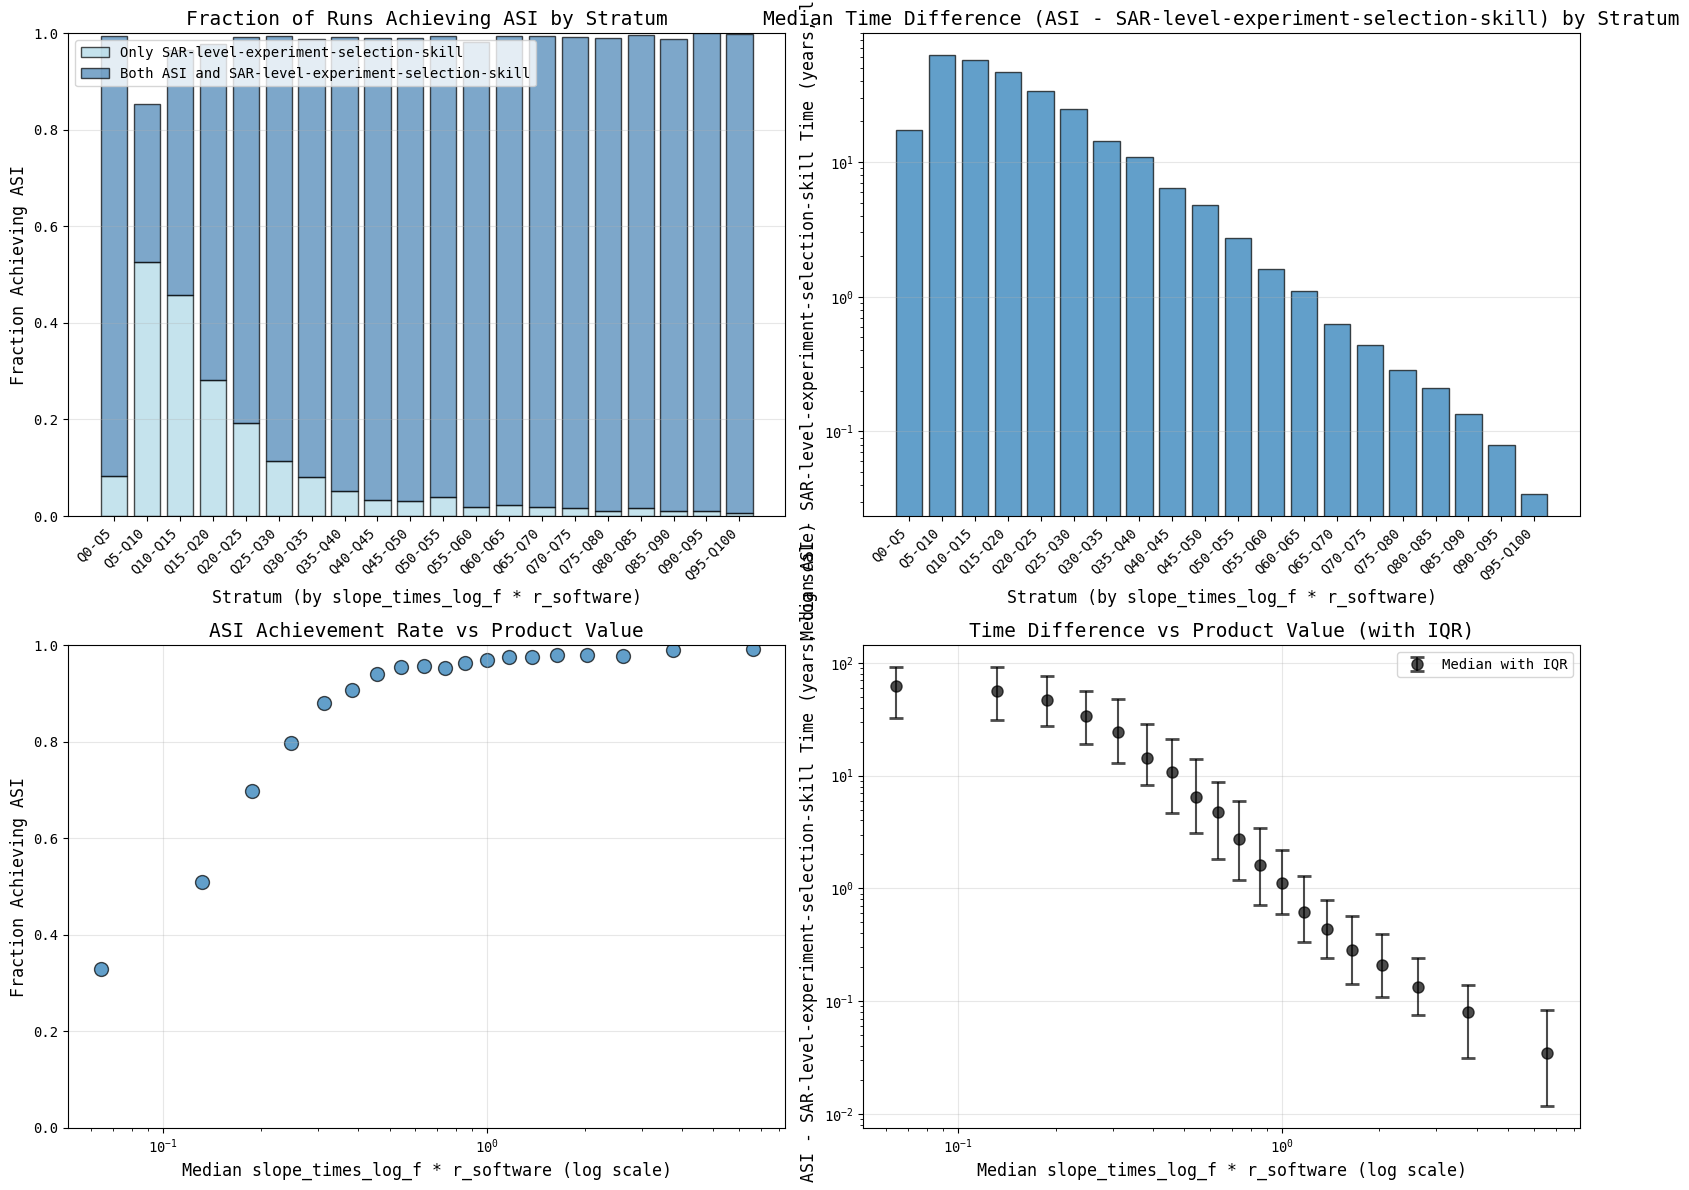

In [ ]:
# Analyze ASI vs SAR
results_asi_sar = analyze_milestone_stratification(df, 'ASI', 'SAR-level-experiment-selection-skill')


Using columns:
  slope_times_log_f
  r_software
  milestone.ASI.time
  milestone.AC.time

Filtering diagnostics:
  Total runs in dataframe: 10,000
  Runs with slope_times_log_f non-NaN: 9,436 (94.36%)
  Runs with r_software non-NaN: 9,436 (94.36%)
  Runs with both non-NaN: 9,436 (94.36%)
  Runs excluded from stratification: 564 (5.64%)

Stratification by slope_times_log_f * r_software (ASI vs AC):
Stratum              Total         ASI Achieved     Fraction   Both Achieved     Median Diff       Mean Diff        P25 Diff        P75 Diff                  Product Range
--------------------------------------------------------------------------------------------------------------------------------------------
Q0-Q5                  472                  430       91.10%             430           20.72           33.91            8.05           49.46               [-19.605, 0.002]
Q5-Q10                 472                  155       32.84%             155           74.28           76.71      

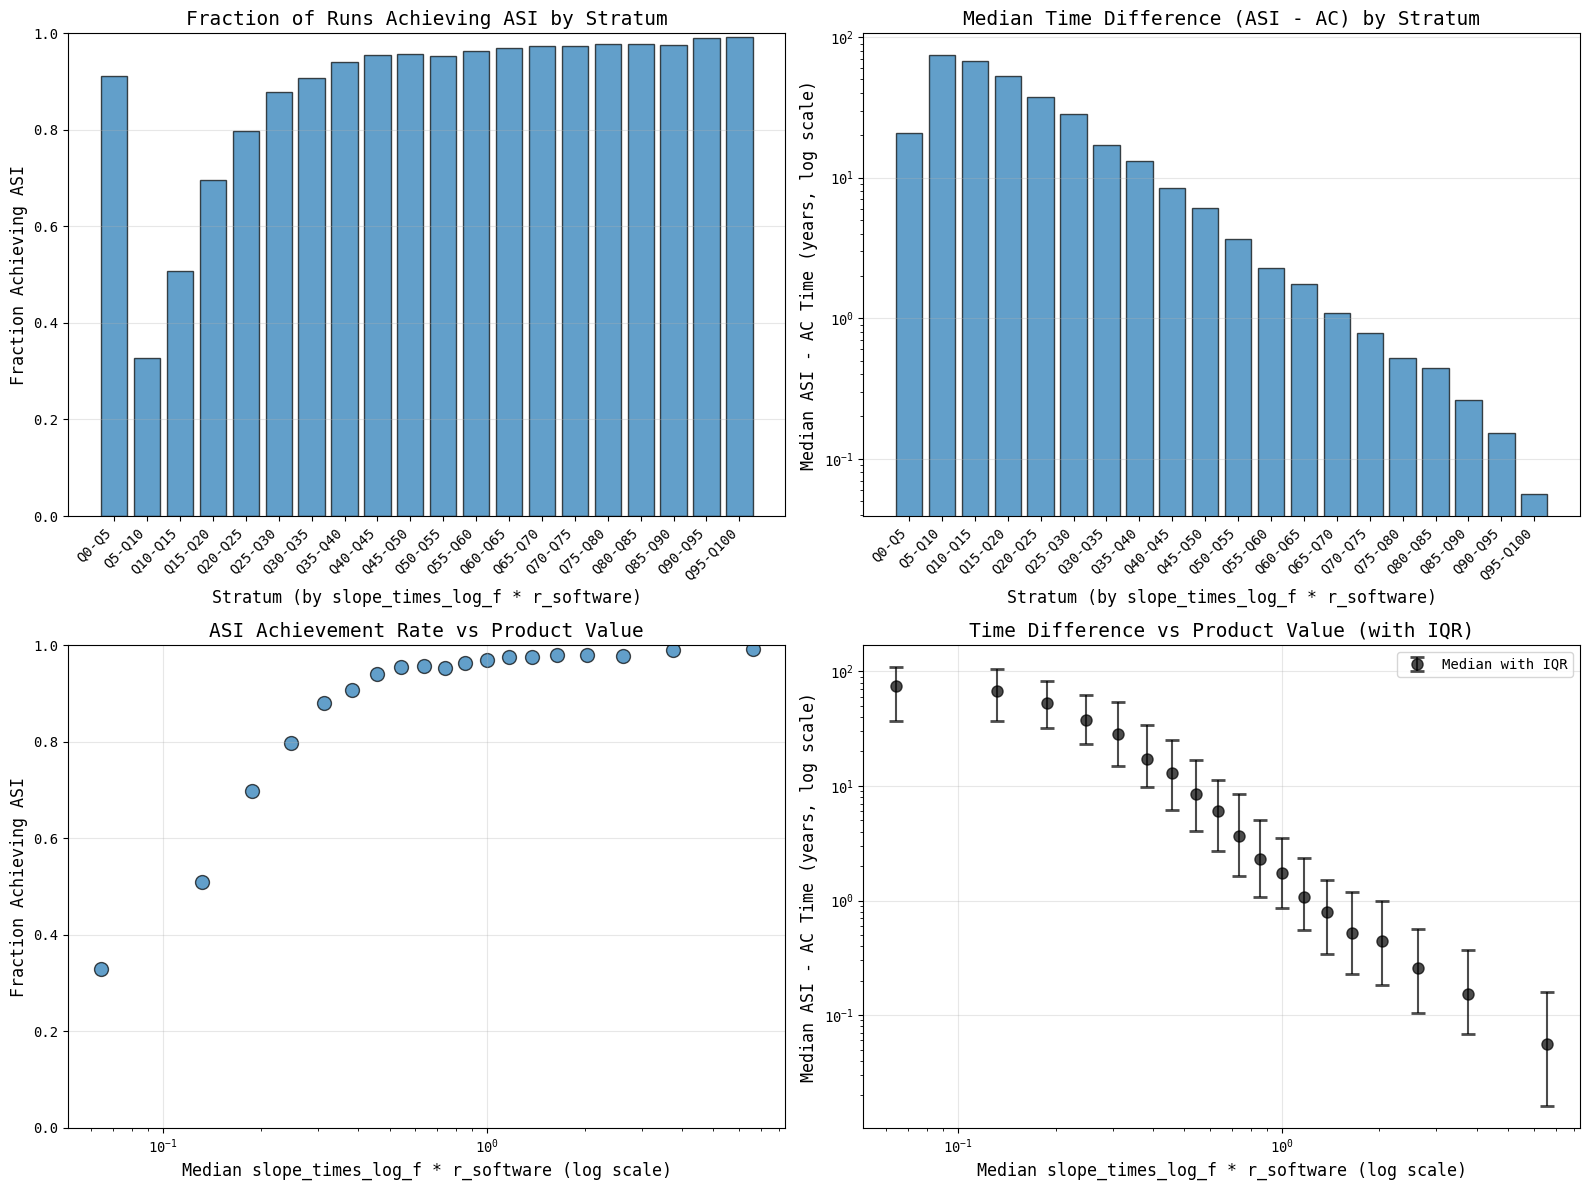

In [ ]:
# Analyze ASI vs AC
results_asi_ac = analyze_milestone_stratification(df, 'ASI', 'AC')


Total runs with both ASI and SAR achieved: 8,320

Statistics on ASI - SAR time difference:
  Count: 8,320
  Min: 0.004019
  25th percentile: 0.269186
  50th percentile (median): 1.963263
  75th percentile: 14.830796
  Max: 168.411717
  Mean: 14.287781
  Std: 26.516619

  Positive differences: 8,320 (100.00%)
  Non-positive differences: 0 (0.00%)



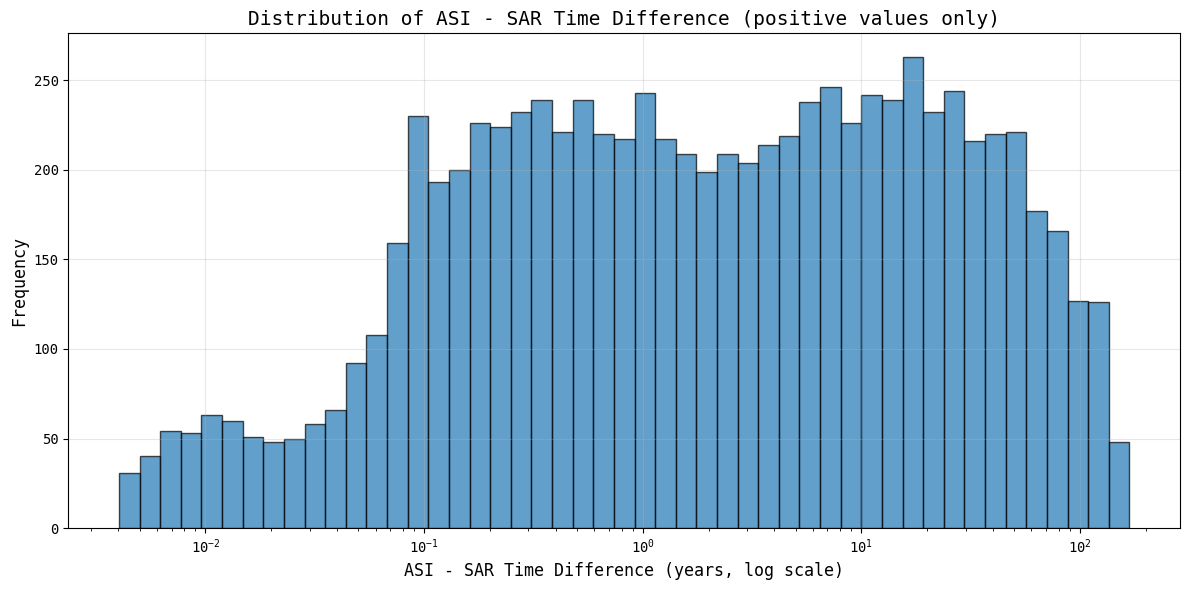

In [ ]:
# Histogram of ASI - SAR time difference (log scale)
import numpy as np
import matplotlib.pyplot as plt

asi_col = 'milestone.ASI.time'
sar_col = 'milestone.SAR-level-experiment-selection-skill.time'

if asi_col in df.columns and sar_col in df.columns:
    # Calculate difference for runs where both are achieved
    both_achieved = df[asi_col].notna() & df[sar_col].notna()
    
    if both_achieved.sum() > 0:
        time_diff = df.loc[both_achieved, asi_col] - df.loc[both_achieved, sar_col]
        
        print(f"Total runs with both ASI and SAR achieved: {len(time_diff):,}")
        print()
        print("Statistics on ASI - SAR time difference:")
        print(f"  Count: {len(time_diff):,}")
        print(f"  Min: {time_diff.min():.6f}")
        print(f"  25th percentile: {time_diff.quantile(0.25):.6f}")
        print(f"  50th percentile (median): {time_diff.quantile(0.50):.6f}")
        print(f"  75th percentile: {time_diff.quantile(0.75):.6f}")
        print(f"  Max: {time_diff.max():.6f}")
        print(f"  Mean: {time_diff.mean():.6f}")
        print(f"  Std: {time_diff.std():.6f}")
        print()
        
        # Filter out non-positive values for log scale
        positive_diff = time_diff[time_diff > 0]
        negative_diff = time_diff[time_diff <= 0]
        
        print(f"  Positive differences: {len(positive_diff):,} ({len(positive_diff)/len(time_diff):.2%})")
        print(f"  Non-positive differences: {len(negative_diff):,} ({len(negative_diff)/len(time_diff):.2%})")
        print()
        
        if len(positive_diff) > 0:
            plt.figure(figsize=(12, 6))
            
            # Use log-spaced bins
            min_val = positive_diff.min()
            max_val = positive_diff.max()
            bins = np.logspace(np.log10(min_val), np.log10(max_val), 50)
            
            plt.hist(positive_diff, bins=bins, edgecolor='black', alpha=0.7)
            plt.xscale('log')
            plt.xlabel('ASI - SAR Time Difference (years, log scale)', fontsize=12)
            plt.ylabel('Frequency', fontsize=12)
            plt.title('Distribution of ASI - SAR Time Difference (positive values only)', fontsize=14)
            plt.grid(True, alpha=0.3, axis='both')
            plt.tight_layout()
            plt.show()
        else:
            print("No positive differences found for log scale histogram")
    else:
        print("No runs found with both ASI and SAR achieved")
else:
    missing_cols = []
    if asi_col not in df.columns:
        missing_cols.append(asi_col)
    if sar_col not in df.columns:
        missing_cols.append(sar_col)
    print(f"Error: Missing columns: {missing_cols}")


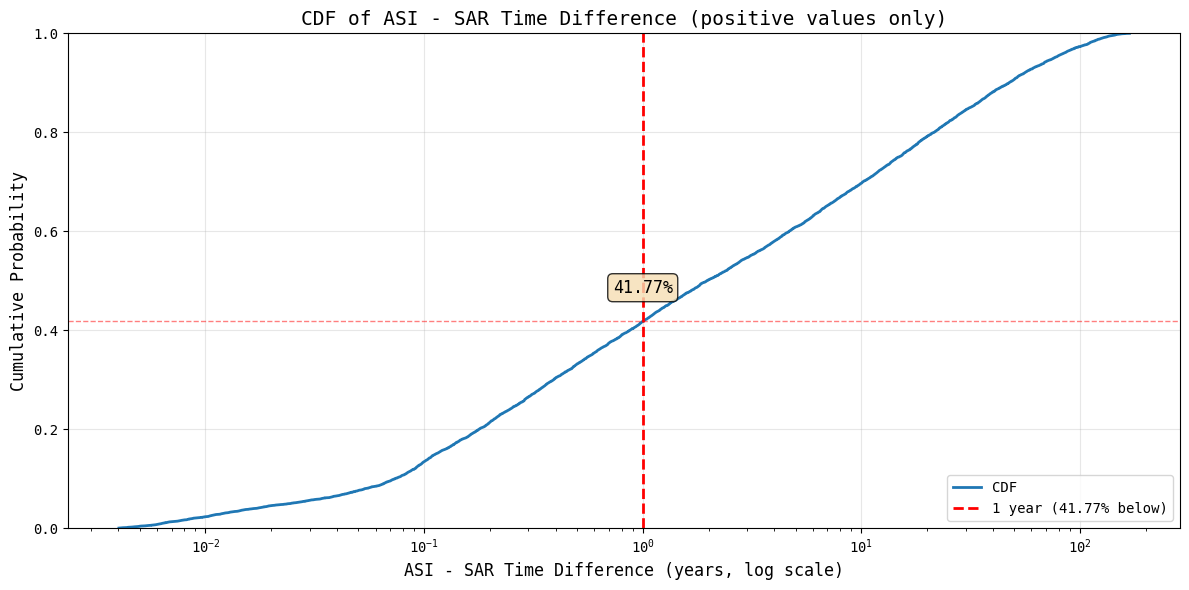

Key percentiles of ASI - SAR time difference:
    10th percentile: 0.073767 years
    25th percentile: 0.269186 years
    50th percentile: 1.963263 years
    75th percentile: 14.830796 years
    90th percentile: 47.290062 years
    95th percentile: 75.949395 years
    99th percentile: 125.847480 years

Fraction below 1 year: 41.77%


In [ ]:
# CDF of ASI - SAR time difference
import numpy as np
import matplotlib.pyplot as plt

asi_col = 'milestone.ASI.time'
sar_col = 'milestone.SAR-level-experiment-selection-skill.time'

if asi_col in df.columns and sar_col in df.columns:
    # Calculate difference for runs where both are achieved
    both_achieved = df[asi_col].notna() & df[sar_col].notna()
    
    if both_achieved.sum() > 0:
        time_diff = df.loc[both_achieved, asi_col] - df.loc[both_achieved, sar_col]
        
        # Filter out non-positive values for log scale
        positive_diff = time_diff[time_diff > 0]
        
        if len(positive_diff) > 0:
            # Create CDF
            sorted_diff = np.sort(positive_diff)
            n = len(sorted_diff)
            cdf_values = np.arange(1, n + 1) / n
            
            # Calculate fraction below 1 year
            fraction_below_1yr = (positive_diff < 1.0).sum() / len(positive_diff)
            
            # Find the CDF value at 1 year (interpolate if needed)
            if 1.0 < sorted_diff.min():
                cdf_at_1yr = 0.0
            elif 1.0 > sorted_diff.max():
                cdf_at_1yr = 1.0
            else:
                # Find the index where 1.0 would be inserted
                idx = np.searchsorted(sorted_diff, 1.0)
                if idx == 0:
                    cdf_at_1yr = 0.0
                elif idx >= n:
                    cdf_at_1yr = 1.0
                else:
                    # Linear interpolation
                    cdf_at_1yr = cdf_values[idx - 1] + (cdf_values[idx] - cdf_values[idx - 1]) * \
                                 (1.0 - sorted_diff[idx - 1]) / (sorted_diff[idx] - sorted_diff[idx - 1])
            
            plt.figure(figsize=(12, 6))
            plt.plot(sorted_diff, cdf_values, linewidth=2, label='CDF')
            
            # Add vertical line at 1 year
            plt.axvline(x=1.0, color='red', linestyle='--', linewidth=2, label=f'1 year ({fraction_below_1yr:.2%} below)')
            
            # Add horizontal line at the CDF value
            plt.axhline(y=cdf_at_1yr, color='red', linestyle='--', linewidth=1, alpha=0.5)
            
            # Add text annotation
            plt.text(1.0, cdf_at_1yr + 0.05, f'{fraction_below_1yr:.2%}', 
                    fontsize=12, ha='center', va='bottom', 
                    bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))
            
            plt.xscale('log')
            plt.xlabel('ASI - SAR Time Difference (years, log scale)', fontsize=12)
            plt.ylabel('Cumulative Probability', fontsize=12)
            plt.title('CDF of ASI - SAR Time Difference (positive values only)', fontsize=14)
            plt.grid(True, alpha=0.3, axis='both')
            plt.ylim(0, 1)
            plt.legend(loc='lower right')
            plt.tight_layout()
            plt.show()
            
            # Print some key percentiles
            print("Key percentiles of ASI - SAR time difference:")
            percentiles = [0.1, 0.25, 0.5, 0.75, 0.9, 0.95, 0.99]
            for p in percentiles:
                val = np.percentile(positive_diff, p * 100)
                print(f"  {p*100:4.0f}th percentile: {val:.6f} years")
            print()
            print(f"Fraction below 1 year: {fraction_below_1yr:.2%}")
        else:
            print("No positive differences found for CDF")
    else:
        print("No runs found with both ASI and SAR achieved")
else:
    missing_cols = []
    if asi_col not in df.columns:
        missing_cols.append(asi_col)
    if sar_col not in df.columns:
        missing_cols.append(sar_col)
    print(f"Error: Missing columns: {missing_cols}")


In [ ]:
# Check if ASI ever happens before SAR
import numpy as np

asi_col = 'milestone.ASI.time'
sar_col = 'milestone.SAR-level-experiment-selection-skill.time'

if asi_col in df.columns and sar_col in df.columns:
    # Get runs where both are achieved
    both_achieved = df[asi_col].notna() & df[sar_col].notna()
    
    if both_achieved.sum() > 0:
        asi_times = df.loc[both_achieved, asi_col]
        sar_times = df.loc[both_achieved, sar_col]
        time_diff = asi_times - sar_times
        
        total_both = len(time_diff)
        
        # ASI happens before SAR means ASI.time < SAR.time, so time_diff < 0
        asi_before_sar = time_diff < 0
        sar_before_asi = time_diff > 0
        same_time = time_diff == 0
        
        asi_before_sar_count = asi_before_sar.sum()
        sar_before_asi_count = sar_before_asi.sum()
        same_time_count = same_time.sum()
        
        print(f"Runs where both ASI and SAR are achieved: {total_both:,}")
        print()
        print("Timing relationship:")
        print(f"  ASI happens before SAR: {asi_before_sar_count:,} ({asi_before_sar_count/total_both:.2%})")
        print(f"  SAR happens before ASI: {sar_before_asi_count:,} ({sar_before_asi_count/total_both:.2%})")
        print(f"  Same time: {same_time_count:,} ({same_time_count/total_both:.2%})")
        print()
        
        if asi_before_sar_count > 0:
            print("YES - ASI happens before SAR in some runs!")
            print()
            print("Statistics for runs where ASI happens before SAR:")
            asi_before_sar_diff = time_diff[asi_before_sar]
            print(f"  Count: {len(asi_before_sar_diff):,}")
            print(f"  Min time difference (ASI - SAR): {asi_before_sar_diff.min():.6f} years")
            print(f"  Median time difference: {asi_before_sar_diff.median():.6f} years")
            print(f"  Mean time difference: {asi_before_sar_diff.mean():.6f} years")
            print(f"  Max time difference: {asi_before_sar_diff.max():.6f} years")
            print()
            
            # Show some examples
            print("Example runs (first 10):")
            example_indices = df.loc[both_achieved].index[asi_before_sar][:10]
            for idx in example_indices:
                asi_time = df.loc[idx, asi_col]
                sar_time = df.loc[idx, sar_col]
                diff = asi_time - sar_time
                print(f"  Run {idx}: ASI={asi_time:.4f}, SAR={sar_time:.4f}, diff={diff:.4f} years")
        else:
            print("NO - ASI never happens before SAR.")
            print("In all runs where both are achieved, SAR happens before or at the same time as ASI.")
        
        if sar_before_asi_count > 0:
            print()
            print("Statistics for runs where SAR happens before ASI:")
            sar_before_asi_diff = time_diff[sar_before_asi]
            print(f"  Count: {len(sar_before_asi_diff):,}")
            print(f"  Min time difference (ASI - SAR): {sar_before_asi_diff.min():.6f} years")
            print(f"  Median time difference: {sar_before_asi_diff.median():.6f} years")
            print(f"  Mean time difference: {sar_before_asi_diff.mean():.6f} years")
            print(f"  Max time difference: {sar_before_asi_diff.max():.6f} years")
    else:
        print("No runs found with both ASI and SAR achieved")
else:
    missing_cols = []
    if asi_col not in df.columns:
        missing_cols.append(asi_col)
    if sar_col not in df.columns:
        missing_cols.append(sar_col)
    print(f"Error: Missing columns: {missing_cols}")


Runs where both ASI and SAR are achieved: 8,320

Timing relationship:
  ASI happens before SAR: 0 (0.00%)
  SAR happens before ASI: 8,320 (100.00%)
  Same time: 0 (0.00%)

NO - ASI never happens before SAR.
In all runs where both are achieved, SAR happens before or at the same time as ASI.

Statistics for runs where SAR happens before ASI:
  Count: 8,320
  Min time difference (ASI - SAR): 0.004019 years
  Median time difference: 1.963263 years
  Mean time difference: 14.287781 years
  Max time difference: 168.411717 years
